# Level 5 Kaggle Reference Model
Author: **Guido Zuidhof** - [gzuidhof@lyft.com](mailto:gzuidhof@lyft.com)

---

In this Kernel we provide an end-to-end example solution for the Lyft Level 5 Kaggle competition.

We train a [U-Net](https://arxiv.org/abs/1505.04597) fully convolutional neural network to predict whether a car or other object is present for every pixel in a birds eye view of the world centered on the car. We can then threshold this probability map and fit boxes around each of the detections.

You can expect to train the model in a few hours on a modern GPU, with inference times under 30ms per image.

### Outline

##### A. Creating an index and splitting into train and validation scenes
1. Loading the dataset
2. Creating a dataframe with one scene per row.
3. Splitting all data into a train and validation set by car

#### B. Creating input and targets
1. We produce top-down images and targets
2. Running this on all of the data in parallel

#### C. Training a network to segment objects
1. Defining datasets / dataloaders
2. Defining the network architecture (U-net)
3. Training the model

#### D. Inference and postprocessing
4. Predicting our validation set.
5. Thresholding the probability map.
6. Performing a morphological closing operation to filter out tiny objects (presuming they are false positives)
7. Loading the ground truth, backprojecting our predicted boxes into world space

#### F. Evaluation
8. Computing MAP.

In [1]:
# Edit these to point at where the Level 5 dataset lives on your machine.
DATASET_VERSION = 'v1.02-train'
DATASET_ROOT = '../level5dataset/v1.02-train/'

# Our code will generate data, visualization and model checkpoints, they will be persisted to disk in this folder
ARTIFACTS_FOLDER = "./artifacts"

In [2]:
%load_ext autoreload

from datetime import datetime
from functools import partial
import glob
from multiprocessing import Pool

# Disable multiprocesing for numpy/opencv. We already multiprocess ourselves, this would mean every subprocess produces
# even more threads which would lead to a lot of context switching, slowing things down a lot.
import os
os.environ["OMP_NUM_THREADS"] = "1"

import matplotlib.pyplot as plt
%matplotlib inline

import pandas as pd
import cv2
from PIL import Image
import numpy as np
from tqdm import tqdm, tqdm_notebook
import scipy
import scipy.ndimage
import scipy.special
from scipy.spatial.transform import Rotation as R

from lyft_dataset_sdk.lyftdataset import LyftDataset
from lyft_dataset_sdk.utils.data_classes import LidarPointCloud, Box, Quaternion
from lyft_dataset_sdk.utils.geometry_utils import view_points, transform_matrix

## A. Creating an index and splitting into train and validation scenes

In [3]:
level5data = LyftDataset(json_path=DATASET_ROOT + "/v1.02-train", data_path=DATASET_ROOT, verbose=True)
os.makedirs(ARTIFACTS_FOLDER, exist_ok=True)

9 category,
18 attribute,
4 visibility,
15991 instance,
8 sensor,
128 calibrated_sensor,
149072 ego_pose,
148 log,
148 scene,
18634 sample,
149072 sample_data,
539765 sample_annotation,
1 map,
Done loading in 8.0 seconds.
Reverse indexing ...
Done reverse indexing in 2.9 seconds.


We create a Pandas DataFrame with a row for each of the scenes

In [4]:
records = [(level5data.get('sample', record['first_sample_token'])['timestamp'], record) for record in
        level5data.scene]

entries = []

for start_time, record in sorted(records):
    start_time = level5data.get('sample', record['first_sample_token'])['timestamp'] / 1000000

    token = record['token']
    name = record['name']
    date = datetime.utcfromtimestamp(start_time)
    host = "-".join(record['name'].split("-")[:2])
    first_sample_token = record["first_sample_token"]

    entries.append((host, name, date, token, first_sample_token))
            
df = pd.DataFrame(entries, columns=["host", "scene_name", "date", "scene_token", "first_sample_token"])

In [5]:
host_count_df = df.groupby("host")['scene_token'].count()
print(host_count_df)

host
host-a004    42
host-a005     1
host-a006     3
host-a007    26
host-a008     5
host-a009     9
host-a011    51
host-a012     2
host-a015     6
host-a017     3
Name: scene_token, dtype: int64


### Train/Validation split
Let's split the data by car to get a validation set.
Alternatively we could consider doing it by scenes, date, or completely randomly.

In [6]:
validation_hosts = ["host-a007", "host-a008", "host-a009"]

validation_df = df[df["host"].isin(validation_hosts)]
vi = validation_df.index
train_df = df[~df.index.isin(vi)]

In [7]:
len(train_df)

108

In [8]:
classes = ["car", "motorcycle", "bus", "bicycle", "truck", "pedestrian", "other_vehicle", "animal", "emergency_vehicle"]

## B. Creating input and targets

Let's load the first sample in the train set. We can use that to test the functions we'll define next that transform the data to the format we want to input into the model we are training.

In [9]:
sample_token = train_df.first_sample_token.values[0]
sample = level5data.get("sample", sample_token)

sample_lidar_token = sample["data"]["LIDAR_TOP"]
lidar_data = level5data.get("sample_data", sample_lidar_token)
lidar_filepath = level5data.get_sample_data_path(sample_lidar_token)

ego_pose = level5data.get("ego_pose", lidar_data["ego_pose_token"])
calibrated_sensor = level5data.get("calibrated_sensor", lidar_data["calibrated_sensor_token"])

# Homogeneous transformation matrix from car frame to world frame.
global_from_car = transform_matrix(ego_pose['translation'],
                                   Quaternion(ego_pose['rotation']), inverse=False)

# Homogeneous transformation matrix from sensor coordinate frame to ego car frame.
car_from_sensor = transform_matrix(calibrated_sensor['translation'], Quaternion(calibrated_sensor['rotation']),
                                    inverse=False)

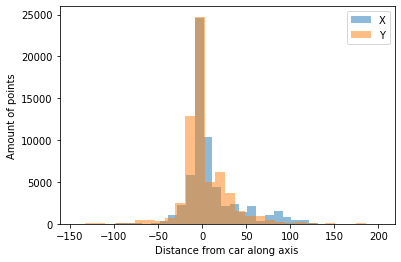

In [10]:
lidar_pointcloud = LidarPointCloud.from_file(lidar_filepath)

# The lidar pointcloud is defined in the sensor's reference frame.
# We want it in the car's reference frame, so we transform each point
lidar_pointcloud.transform(car_from_sensor)

# A sanity check, the points should be centered around 0 in car space.
plt.hist(lidar_pointcloud.points[0], alpha=0.5, bins=30, label="X")
plt.hist(lidar_pointcloud.points[1], alpha=0.5, bins=30, label="Y")
plt.legend()
plt.xlabel("Distance from car along axis")
plt.ylabel("Amount of points")
plt.show()

In [11]:
map_mask = level5data.map[0]["mask"]

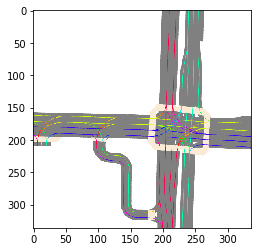

In [12]:
def get_semantic_map_around_ego(map_mask, ego_pose, voxel_size, output_shape):

    def crop_image(image: np.array,
                           x_px: int,
                           y_px: int,
                           axes_limit_px: int) -> np.array:
                x_min = int(x_px - axes_limit_px)
                x_max = int(x_px + axes_limit_px)
                y_min = int(y_px - axes_limit_px)
                y_max = int(y_px + axes_limit_px)

                cropped_image = image[y_min:y_max, x_min:x_max]

                return cropped_image

    pixel_coords = map_mask.to_pixel_coords(ego_pose['translation'][0], ego_pose['translation'][1])

    extent = voxel_size*output_shape[0]*0.5
    scaled_limit_px = int(extent * (1.0 / (map_mask.resolution)))
    mask_raster = map_mask.mask()

    cropped = crop_image(mask_raster, pixel_coords[0], pixel_coords[1], int(scaled_limit_px * np.sqrt(2)))

    ypr_rad = Quaternion(ego_pose['rotation']).yaw_pitch_roll
    yaw_deg = -np.degrees(ypr_rad[0])

    rotated_cropped = np.array(Image.fromarray(cropped).rotate(yaw_deg))
    ego_centric_map = crop_image(rotated_cropped, rotated_cropped.shape[1] / 2, rotated_cropped.shape[0] / 2,
                                 scaled_limit_px)[::-1]
    
    ego_centric_map = cv2.resize(ego_centric_map, output_shape[:2], cv2.INTER_NEAREST)
    return ego_centric_map.astype(np.float32)/255
    
ego_centric_map = get_semantic_map_around_ego(map_mask, ego_pose, voxel_size=0.4, output_shape=(336,336)) 
plt.imshow(ego_centric_map)
plt.show()

As input for our network we voxelize the LIDAR points. That means that we go from a list of coordinates of points, to a X by Y by Z space.

In [13]:
def create_transformation_matrix_to_voxel_space(shape, voxel_size, offset):
    """
    Constructs a transformation matrix given an output voxel shape such that (0,0,0) ends up in the center.
    Voxel_size defines how large every voxel is in world coordinate, (1,1,1) would be the same as Minecraft voxels.
    
    An offset per axis in world coordinates (metric) can be provided, this is useful for Z (up-down) in lidar points.
    """
    
    shape, voxel_size, offset = np.array(shape), np.array(voxel_size), np.array(offset)
    
    tm = np.eye(4, dtype=np.float32)
    translation = shape/2 + offset/voxel_size
    
    tm = tm * np.array(np.hstack((1/voxel_size, [1])))

    tm[:3, 3] = np.transpose(translation)
    return tm

def transform_points(points, transf_matrix):
    """
    Transform (3,N) or (4,N) points using transformation matrix.
    """
    if points.shape[0] not in [3,4]:
        raise Exception("Points input should be (3,N) or (4,N) shape, received {}".format(points.shape))
    return transf_matrix.dot(np.vstack((points[:3, :], np.ones(points.shape[1]))))[:3, :]

# Let's try it with some example values
tm = create_transformation_matrix_to_voxel_space(shape=(100,100,4), voxel_size=(0.5,0.5,0.5), offset=(0,0,0.5))
p = transform_points(np.array([[10, 10, 0, 0, 0], [10, 5, 0, 0, 0],[0, 0, 0, 2, 0]], dtype=np.float32), tm)
print(p)

[[70. 70. 50. 50. 50.]
 [70. 60. 50. 50. 50.]
 [ 3.  3.  3.  7.  3.]]


In [14]:
def car_to_voxel_coords(points, shape, voxel_size, z_offset=0):
    if len(shape) != 3:
        raise Exception("Voxel volume shape should be 3 dimensions (x,y,z)")
        
    if len(points.shape) != 2 or points.shape[0] not in [3, 4]:
        raise Exception("Input points should be (3,N) or (4,N) in shape, found {}".format(points.shape))

    tm = create_transformation_matrix_to_voxel_space(shape, voxel_size, (0, 0, z_offset))
    p = transform_points(points, tm)
    return p

def create_voxel_pointcloud(points, shape, voxel_size=(0.5,0.5,1), z_offset=0):

    points_voxel_coords = car_to_voxel_coords(points.copy(), shape, voxel_size, z_offset)
    points_voxel_coords = points_voxel_coords[:3].transpose(1,0)
    points_voxel_coords = np.int0(points_voxel_coords)
    
    bev = np.zeros(shape, dtype=np.float32)
    bev_shape = np.array(shape)

    within_bounds = (np.all(points_voxel_coords >= 0, axis=1) * np.all(points_voxel_coords < bev_shape, axis=1))
    
    points_voxel_coords = points_voxel_coords[within_bounds]
    coord, count = np.unique(points_voxel_coords, axis=0, return_counts=True)
        
    # Note X and Y are flipped:
    bev[coord[:,1], coord[:,0], coord[:,2]] = count
    
    return bev

def normalize_voxel_intensities(bev, max_intensity=16):
    return (bev/max_intensity).clip(0,1)


voxel_size = (0.4,0.4,1.5)
z_offset = -2.0
bev_shape = (336, 336, 3)

bev = create_voxel_pointcloud(lidar_pointcloud.points, bev_shape, voxel_size=voxel_size, z_offset=z_offset)

# So that the values in the voxels range from 0,1 we set a maximum intensity.
bev = normalize_voxel_intensities(bev)

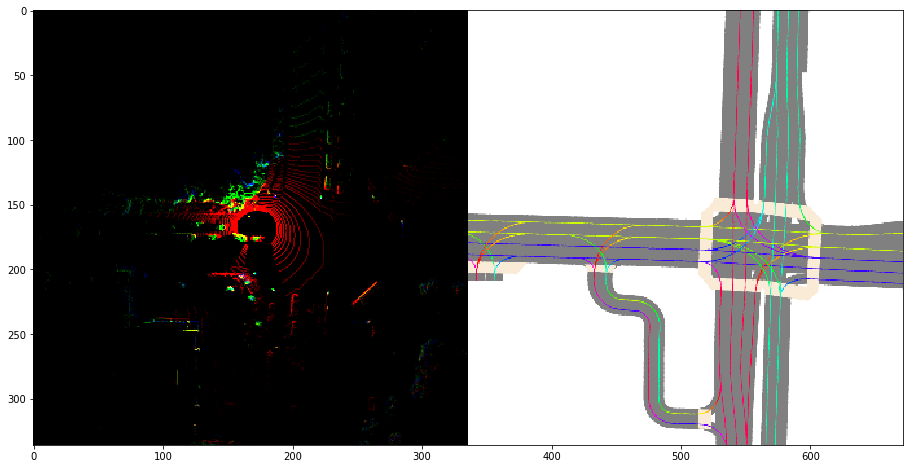

In [15]:
plt.figure(figsize=(16,8))
plt.imshow(np.hstack((bev, ego_centric_map)))
plt.show()

Above is an example of what the input for our network will look like. It's a top-down projection of the world around the car (the car faces to the right in the image). The height of the lidar points are separated into three bins, which visualized like this these are the RGB channels of the image.

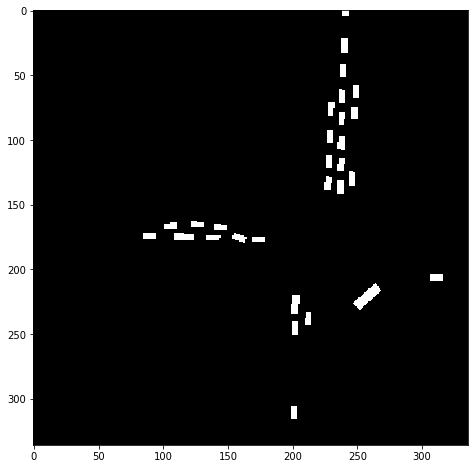

In [16]:
boxes = level5data.get_boxes(sample_lidar_token)

target_im = np.zeros(bev.shape[:3], dtype=np.uint8)

def move_boxes_to_car_space(boxes, ego_pose):
    """
    Move boxes from world space to car space.
    Note: mutates input boxes.
    """
    translation = -np.array(ego_pose['translation'])
    rotation = Quaternion(ego_pose['rotation']).inverse
    
    for box in boxes:
        # Bring box to car space
        box.translate(translation)
        box.rotate(rotation)
        
def scale_boxes(boxes, factor):
    """
    Note: mutates input boxes
    """
    for box in boxes:
        box.wlh = box.wlh * factor

def draw_boxes(im, voxel_size, boxes, classes, z_offset=0.0):
    for box in boxes:
        # We only care about the bottom corners
        corners = box.bottom_corners()
        corners_voxel = car_to_voxel_coords(corners, im.shape, voxel_size, z_offset).transpose(1,0)
        corners_voxel = corners_voxel[:,:2] # Drop z coord

        class_color = classes.index(box.name) + 1
        
        if class_color == 0:
            raise Exception("Unknown class: {}".format(box.name))

        cv2.drawContours(im, np.int0([corners_voxel]), 0, (class_color, class_color, class_color), -1)



move_boxes_to_car_space(boxes, ego_pose)
scale_boxes(boxes, 0.8)
draw_boxes(target_im, voxel_size, boxes, classes, z_offset=z_offset)

plt.figure(figsize=(8,8))
plt.imshow((target_im > 0).astype(np.float32), cmap='Set2')
plt.show()

These are the annotations in the same top-down frame, Below we plot the same scene using the NuScenes SDK. Don't worry about it being flipped.

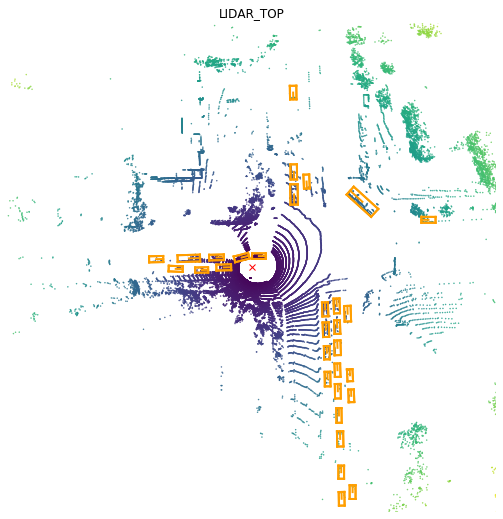

In [17]:
def visualize_lidar_of_sample(sample_token, axes_limit=80):
    sample = level5data.get("sample", sample_token)
    sample_lidar_token = sample["data"]["LIDAR_TOP"]
    level5data.render_sample_data(sample_lidar_token, axes_limit=axes_limit)
visualize_lidar_of_sample(sample_token)

Now we will run this on all samples in the train and validation set, and write the input and target images to their respective folders.

In [18]:
# Some hyperparameters we'll need to define for the system
voxel_size = (0.4, 0.4, 1.5)
z_offset = -2.0
bev_shape = (336, 336, 3)

# We scale down each box so they are more separated when projected into our coarse voxel space.
box_scale = 0.8

In [19]:
# "bev" stands for birds eye view
train_data_folder = os.path.join(ARTIFACTS_FOLDER, "bev_train_data")
validation_data_folder = os.path.join(ARTIFACTS_FOLDER, "./bev_validation_data")

In [20]:
NUM_WORKERS = os.cpu_count()

def prepare_training_data_for_scene(first_sample_token, output_folder, bev_shape, voxel_size, z_offset, box_scale):
    """
    Given a first sample token (in a scene), output rasterized input volumes and targets in birds-eye-view perspective.
    

    """
    sample_token = first_sample_token
    
    while sample_token:
        
        sample = level5data.get("sample", sample_token)

        sample_lidar_token = sample["data"]["LIDAR_TOP"]
        lidar_data = level5data.get("sample_data", sample_lidar_token)
        lidar_filepath = level5data.get_sample_data_path(sample_lidar_token)

        ego_pose = level5data.get("ego_pose", lidar_data["ego_pose_token"])
        calibrated_sensor = level5data.get("calibrated_sensor", lidar_data["calibrated_sensor_token"])


        global_from_car = transform_matrix(ego_pose['translation'],
                                           Quaternion(ego_pose['rotation']), inverse=False)

        car_from_sensor = transform_matrix(calibrated_sensor['translation'], Quaternion(calibrated_sensor['rotation']),
                                            inverse=False)

        try:
            lidar_pointcloud = LidarPointCloud.from_file(lidar_filepath)
            lidar_pointcloud.transform(car_from_sensor)
        except Exception as e:
            print ("Failed to load Lidar Pointcloud for {}: {}:".format(sample_token, e))
            sample_token = sample["next"]
            continue
        
        bev = create_voxel_pointcloud(lidar_pointcloud.points, bev_shape, voxel_size=voxel_size, z_offset=z_offset)
        bev = normalize_voxel_intensities(bev)

        
        boxes = level5data.get_boxes(sample_lidar_token)

        target = np.zeros_like(bev)

        move_boxes_to_car_space(boxes, ego_pose)
        scale_boxes(boxes, box_scale)
        draw_boxes(target, voxel_size, boxes=boxes, classes=classes, z_offset=z_offset)

        bev_im = np.round(bev*255).astype(np.uint8)
        target_im = target[:,:,0] # take one channel only
        
        semantic_im = get_semantic_map_around_ego(map_mask, ego_pose, voxel_size[0], target_im.shape)
        semantic_im = np.round(semantic_im*255).astype(np.uint8)

        cv2.imwrite(os.path.join(output_folder, "{}_input.png".format(sample_token)), bev_im)
        cv2.imwrite(os.path.join(output_folder, "{}_target.png".format(sample_token)), target_im)
        cv2.imwrite(os.path.join(output_folder, "{}_map.png".format(sample_token)), semantic_im)
        
        sample_token = sample["next"]

for df, data_folder in [(train_df, train_data_folder), (validation_df, validation_data_folder)]:
    print("Preparing data into {} using {} workers".format(data_folder, NUM_WORKERS))
    first_samples = df.first_sample_token.values

    os.makedirs(data_folder, exist_ok=True)
    
    process_func = partial(prepare_training_data_for_scene,
                           output_folder=data_folder, bev_shape=bev_shape, voxel_size=voxel_size, z_offset=z_offset, box_scale=box_scale)

    pool = Pool(NUM_WORKERS)
    for _ in tqdm_notebook(pool.imap_unordered(process_func, first_samples), total=len(first_samples)):
        pass
    pool.close()

Preparing data into ./artifacts/bev_train_data using 56 workers



Preparing data into ./artifacts/./bev_validation_data using 56 workers


## C. Training a network to segment objects

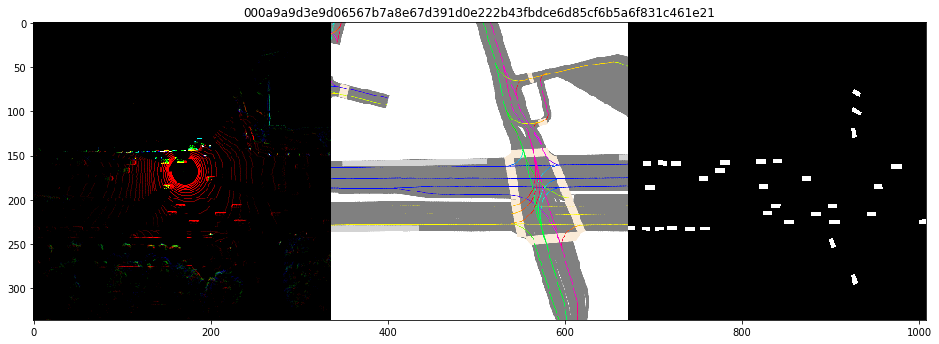

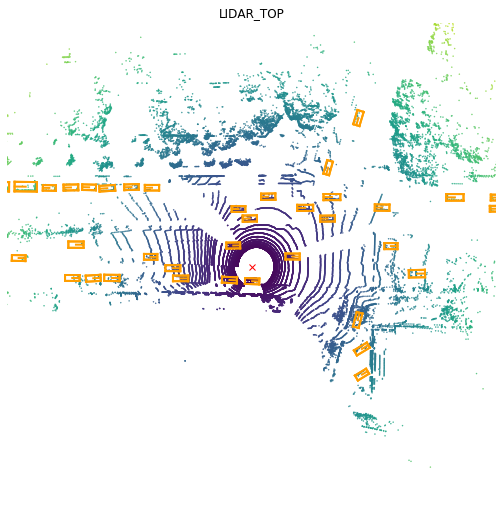

In [21]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data

class BEVImageDataset(torch.utils.data.Dataset):
    def __init__(self, input_filepaths, target_filepaths, map_filepaths=None):
        self.input_filepaths = input_filepaths
        self.target_filepaths = target_filepaths
        self.map_filepaths = map_filepaths
        
        if map_filepaths is not None:
            assert len(input_filepaths) == len(map_filepaths)
        
        assert len(input_filepaths) == len(target_filepaths)

    def __len__(self):
        return len(self.input_filepaths)

    def __getitem__(self, idx):
        input_filepath = self.input_filepaths[idx]
        target_filepath = self.target_filepaths[idx]
        
        sample_token = input_filepath.split("/")[-1].replace("_input.png","")
        
        im = cv2.imread(input_filepath, cv2.IMREAD_UNCHANGED)
        
        if self.map_filepaths:
            map_filepath = self.map_filepaths[idx]
            map_im = cv2.imread(map_filepath, cv2.IMREAD_UNCHANGED)
            im = np.concatenate((im, map_im), axis=2)
        
        target = cv2.imread(target_filepath, cv2.IMREAD_UNCHANGED)
        
        im = im.astype(np.float32)/255
        target = target.astype(np.int64)
        
        im = torch.from_numpy(im.transpose(2,0,1))
        target = torch.from_numpy(target)
        
        return im, target, sample_token

input_filepaths = sorted(glob.glob(os.path.join(train_data_folder, "*_input.png")))
target_filepaths = sorted(glob.glob(os.path.join(train_data_folder, "*_target.png")))
map_filepaths = sorted(glob.glob(os.path.join(train_data_folder, "*_map.png")))

train_dataset = BEVImageDataset(input_filepaths, target_filepaths, map_filepaths)
    
im, target, sample_token = train_dataset[1]
im = im.numpy()
target = target.numpy()

plt.figure(figsize=(16,8))

target_as_rgb = np.repeat(target[...,None], 3, 2)
# Transpose the input volume CXY to XYC order, which is what matplotlib requires.
plt.imshow(np.hstack((im.transpose(1,2,0)[...,:3], im.transpose(1,2,0)[...,3:], target_as_rgb)))
plt.title(sample_token)
plt.show()

visualize_lidar_of_sample(sample_token)

In [22]:
# This implementation was copied from https://github.com/jvanvugt/pytorch-unet, it is MIT licensed.

class UNet(nn.Module):
    def __init__(
        self,
        in_channels=1,
        n_classes=2,
        depth=5,
        wf=6,
        padding=False,
        batch_norm=False,
        up_mode='upconv',
    ):
        """
        Implementation of
        U-Net: Convolutional Networks for Biomedical Image Segmentation
        (Ronneberger et al., 2015)
        https://arxiv.org/abs/1505.04597
        Using the default arguments will yield the exact version used
        in the original paper
        Args:
            in_channels (int): number of input channels
            n_classes (int): number of output channels
            depth (int): depth of the network
            wf (int): number of filters in the first layer is 2**wf
            padding (bool): if True, apply padding such that the input shape
                            is the same as the output.
                            This may introduce artifacts
            batch_norm (bool): Use BatchNorm after layers with an
                               activation function
            up_mode (str): one of 'upconv' or 'upsample'.
                           'upconv' will use transposed convolutions for
                           learned upsampling.
                           'upsample' will use bilinear upsampling.
        """
        super(UNet, self).__init__()
        assert up_mode in ('upconv', 'upsample')
        self.padding = padding
        self.depth = depth
        prev_channels = in_channels
        self.down_path = nn.ModuleList()
        for i in range(depth):
            self.down_path.append(
                UNetConvBlock(prev_channels, 2 ** (wf + i), padding, batch_norm)
            )
            prev_channels = 2 ** (wf + i)

        self.up_path = nn.ModuleList()
        for i in reversed(range(depth - 1)):
            self.up_path.append(
                UNetUpBlock(prev_channels, 2 ** (wf + i), up_mode, padding, batch_norm)
            )
            prev_channels = 2 ** (wf + i)

        self.last = nn.Conv2d(prev_channels, n_classes, kernel_size=1)

    def forward(self, x):
        blocks = []
        for i, down in enumerate(self.down_path):
            x = down(x)
            if i != len(self.down_path) - 1:
                blocks.append(x)
                x = F.max_pool2d(x, 2)

        for i, up in enumerate(self.up_path):
            x = up(x, blocks[-i - 1])

        return self.last(x)


class UNetConvBlock(nn.Module):
    def __init__(self, in_size, out_size, padding, batch_norm):
        super(UNetConvBlock, self).__init__()
        block = []

        block.append(nn.Conv2d(in_size, out_size, kernel_size=3, padding=int(padding)))
        block.append(nn.ReLU())
        if batch_norm:
            block.append(nn.BatchNorm2d(out_size))

        block.append(nn.Conv2d(out_size, out_size, kernel_size=3, padding=int(padding)))
        block.append(nn.ReLU())
        if batch_norm:
            block.append(nn.BatchNorm2d(out_size))

        self.block = nn.Sequential(*block)

    def forward(self, x):
        out = self.block(x)
        return out


class UNetUpBlock(nn.Module):
    def __init__(self, in_size, out_size, up_mode, padding, batch_norm):
        super(UNetUpBlock, self).__init__()
        if up_mode == 'upconv':
            self.up = nn.ConvTranspose2d(in_size, out_size, kernel_size=2, stride=2)
        elif up_mode == 'upsample':
            self.up = nn.Sequential(
                nn.Upsample(mode='bilinear', scale_factor=2),
                nn.Conv2d(in_size, out_size, kernel_size=1),
            )

        self.conv_block = UNetConvBlock(in_size, out_size, padding, batch_norm)

    def center_crop(self, layer, target_size):
        _, _, layer_height, layer_width = layer.size()
        diff_y = (layer_height - target_size[0]) // 2
        diff_x = (layer_width - target_size[1]) // 2
        return layer[
            :, :, diff_y : (diff_y + target_size[0]), diff_x : (diff_x + target_size[1])
        ]

    def forward(self, x, bridge):
        up = self.up(x)
        crop1 = self.center_crop(bridge, up.shape[2:])
        out = torch.cat([up, crop1], 1)
        out = self.conv_block(out)

        return out

We train a U-net fully convolutional neural network.  
We create a U-net that is less deep and with only half the amount of filters compared to the original U-net paper implementation.

In [23]:
def get_unet_model(in_channels=6, num_output_classes=2):
    model = UNet(in_channels=6, n_classes=num_output_classes, wf=5, depth=4, padding=True, up_mode='upsample')
    
    # Optional, for multi GPU training and inference
    model = nn.DataParallel(model)
    return model


In [24]:
def visualize_predictions(input_image, prediction, target, n_images=2, apply_softmax=True):
    """
    Takes as input 3 PyTorch tensors, plots the input image, predictions and targets.
    """
    # Only select the first n images
    prediction = prediction[:n_images]
    target = target[:n_images]
    input_image = input_image[:n_images]

    prediction = prediction.detach().cpu().numpy()
    if apply_softmax:
        prediction = scipy.special.softmax(prediction, axis=1)
    class_one_preds = np.hstack(1-prediction[:,0])

    target = np.hstack(target.detach().cpu().numpy())

    class_rgb = np.repeat(class_one_preds[..., None], 3, axis=2)
    class_rgb[...,2] = 0
    class_rgb[...,1] = target

    
    input_im = np.hstack(input_image.cpu().numpy().transpose(0,2,3,1))
    
    if input_im.shape[2] == 3: # Without semantic map input
        input_im_grayscale = np.repeat(input_im.mean(axis=2)[..., None], 3, axis=2)
        overlayed_im = (input_im_grayscale*0.6 + class_rgb*0.7).clip(0,1)
    else:
        input_map = input_im[...,3:] #With semantic map input
        overlayed_im = (input_map*0.6 + class_rgb*0.7).clip(0,1)

    thresholded_pred = np.repeat(class_one_preds[..., None] > 0.5, 3, axis=2)

    fig = plt.figure(figsize=(12,26))
    plot_im = np.vstack([class_rgb, input_im[...,:3], overlayed_im, thresholded_pred]).clip(0,1).astype(np.float32)
    plt.imshow(plot_im)
    plt.axis("off")
    plt.show()

In [25]:
# We weigh the loss for the 0 class lower to account for (some of) the big class imbalance.
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
class_weights = torch.from_numpy(np.array([0.2] + [1.0]*len(classes), dtype=np.float32))
class_weights = class_weights.to(device)

Epoch 1


/home/gzuidhof/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:2539: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


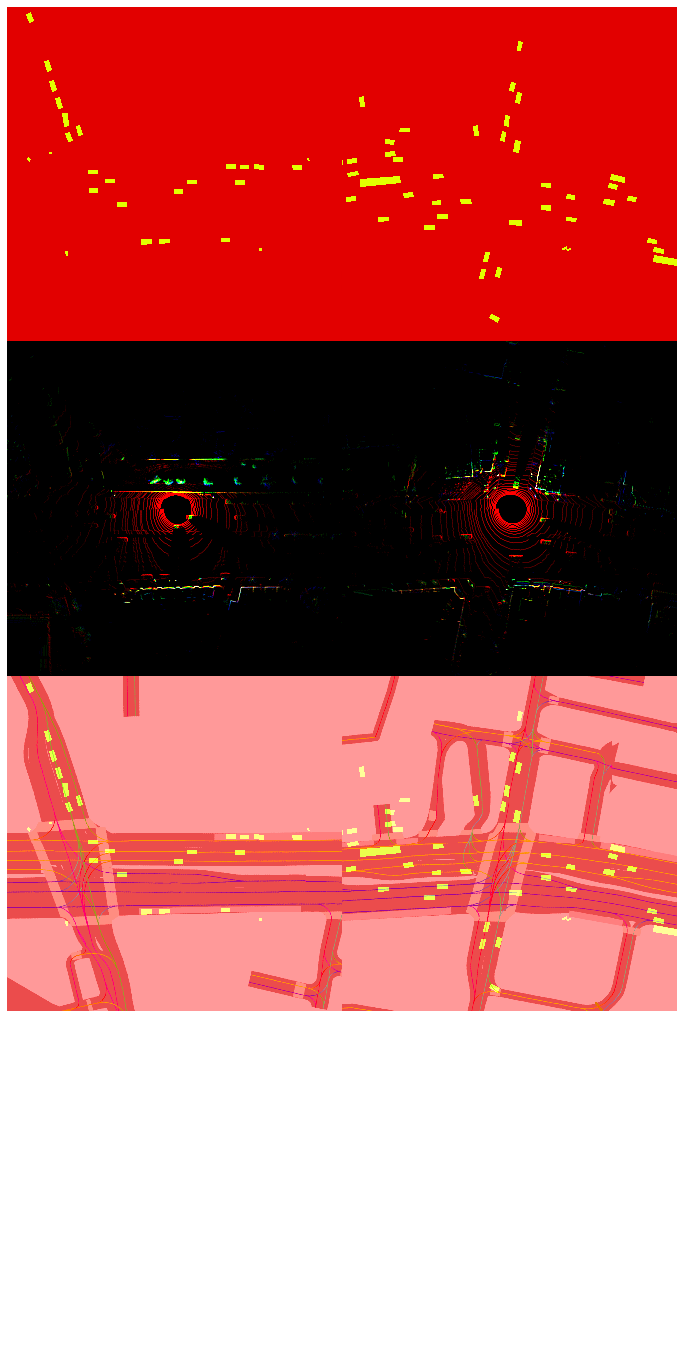


Loss: 0.10674278
Epoch 2


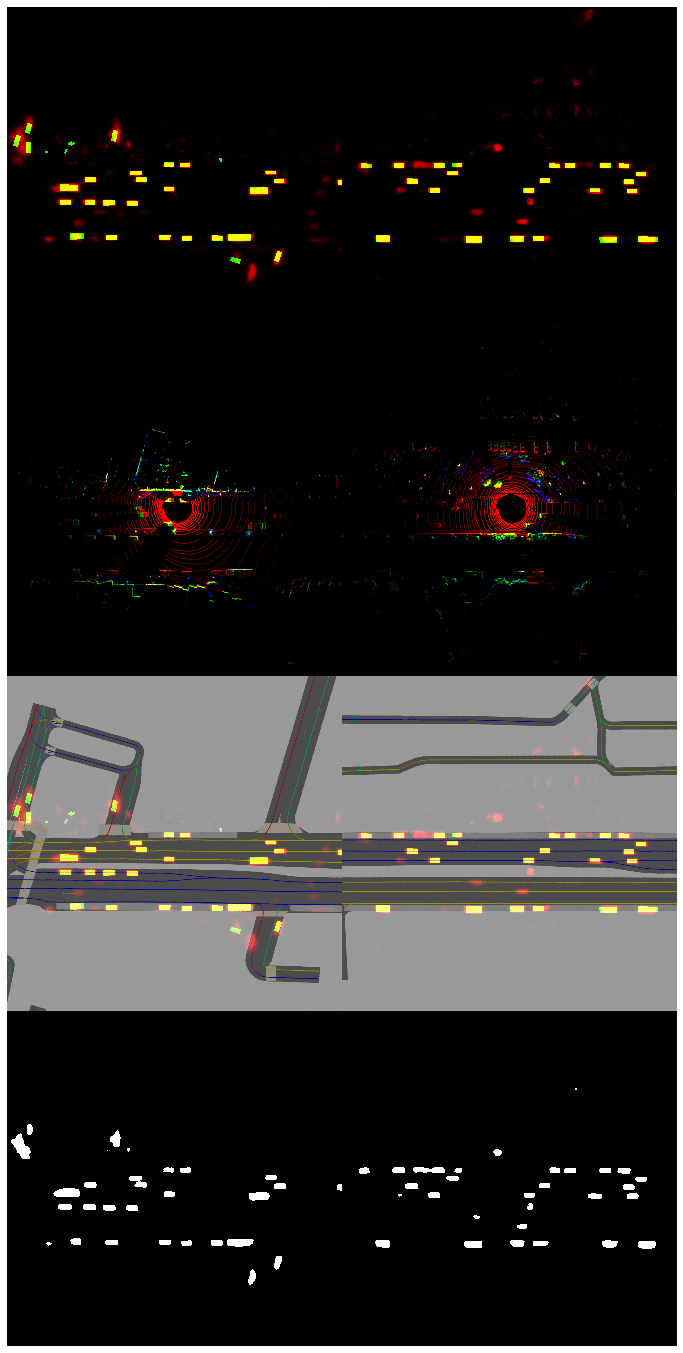


Loss: 0.044704422
Epoch 3


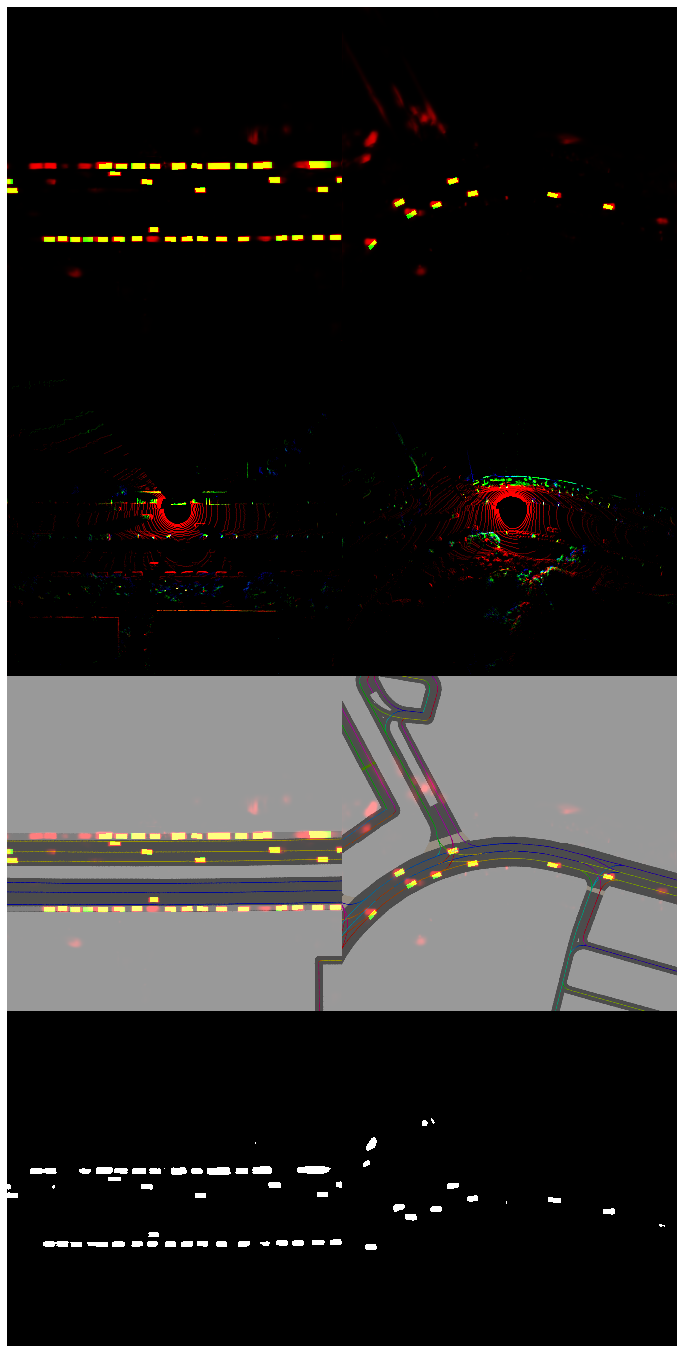


Loss: 0.034443244
Epoch 4


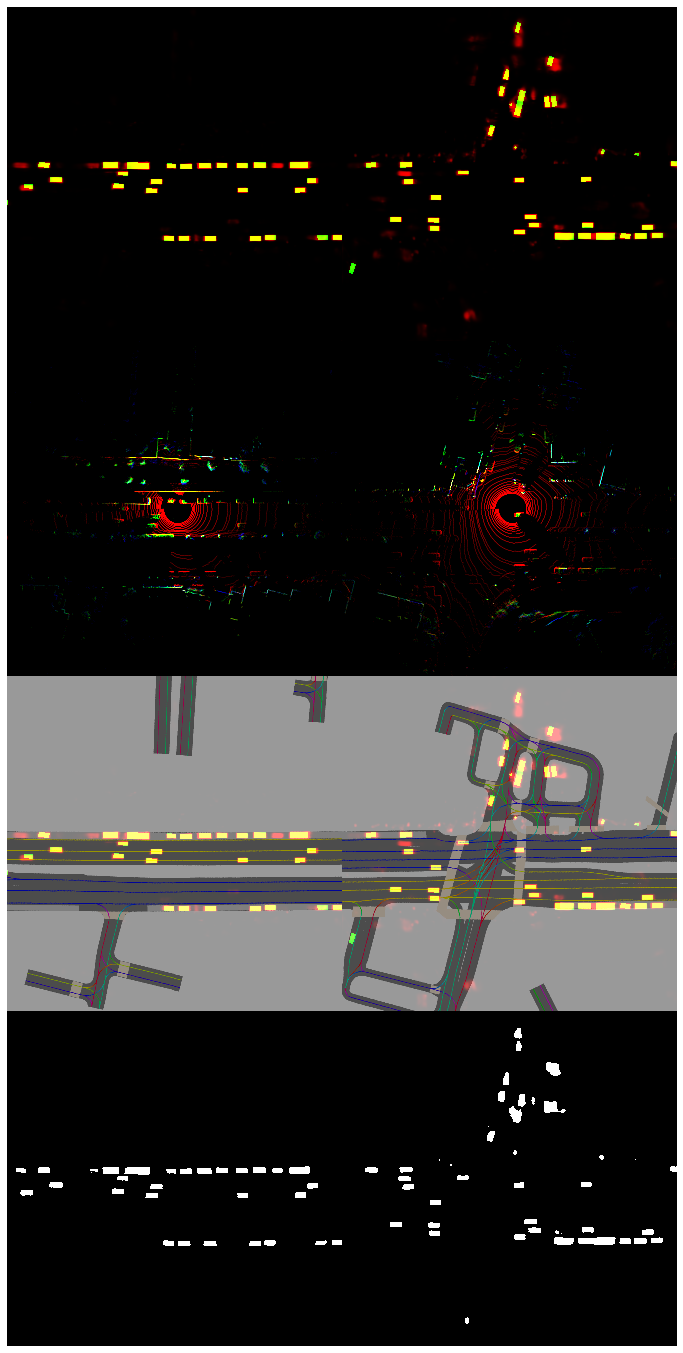


Loss: 0.029417584
Epoch 5


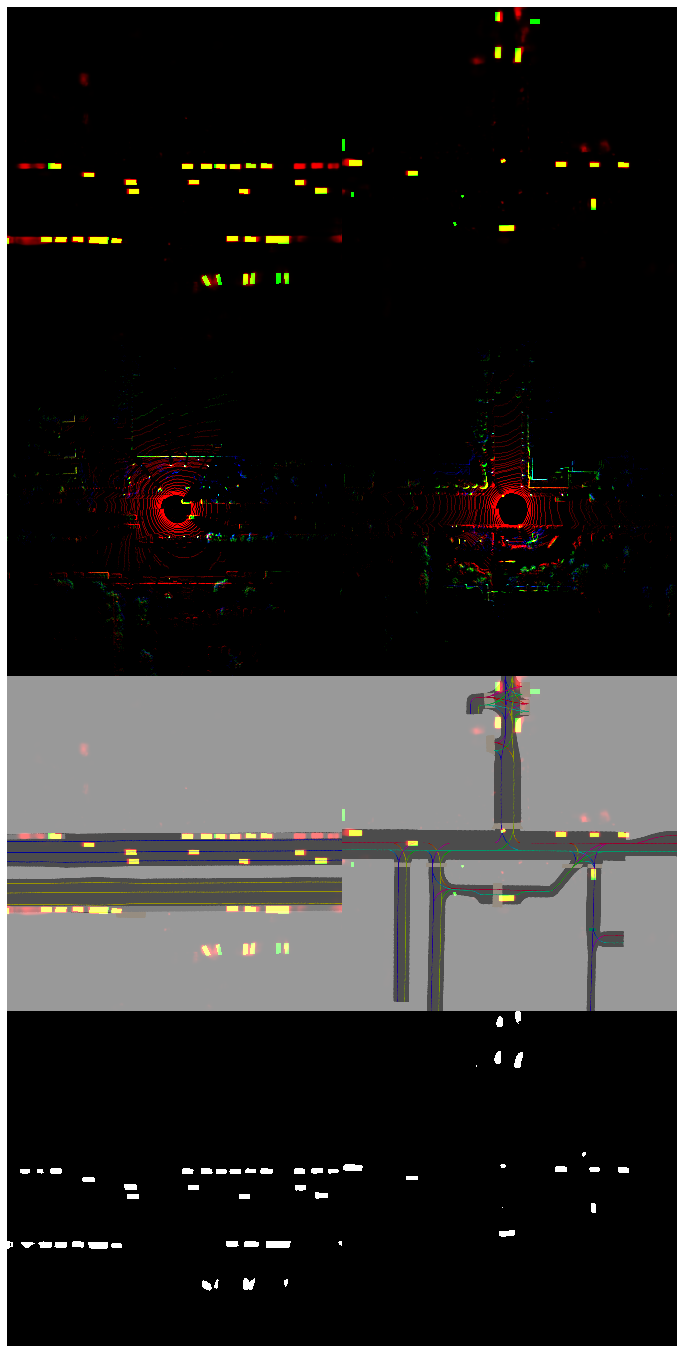


Loss: 0.02631507
Epoch 6


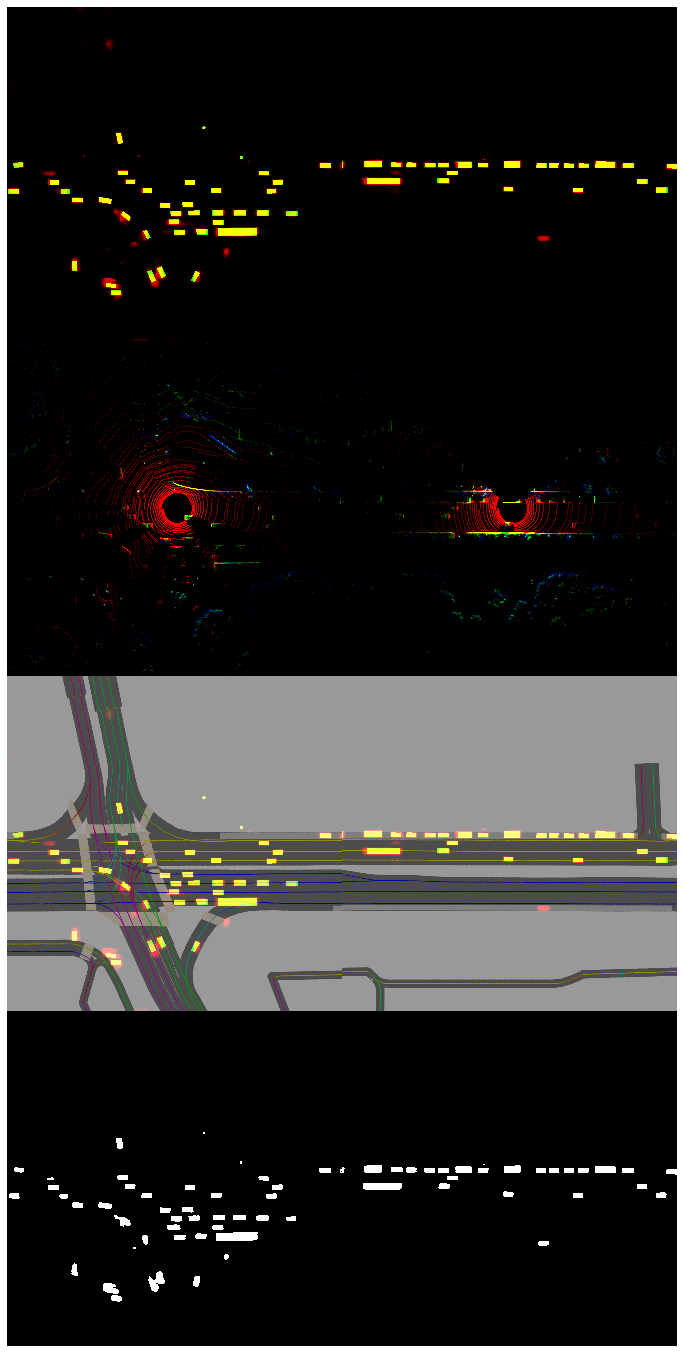


Loss: 0.024392817
Epoch 7


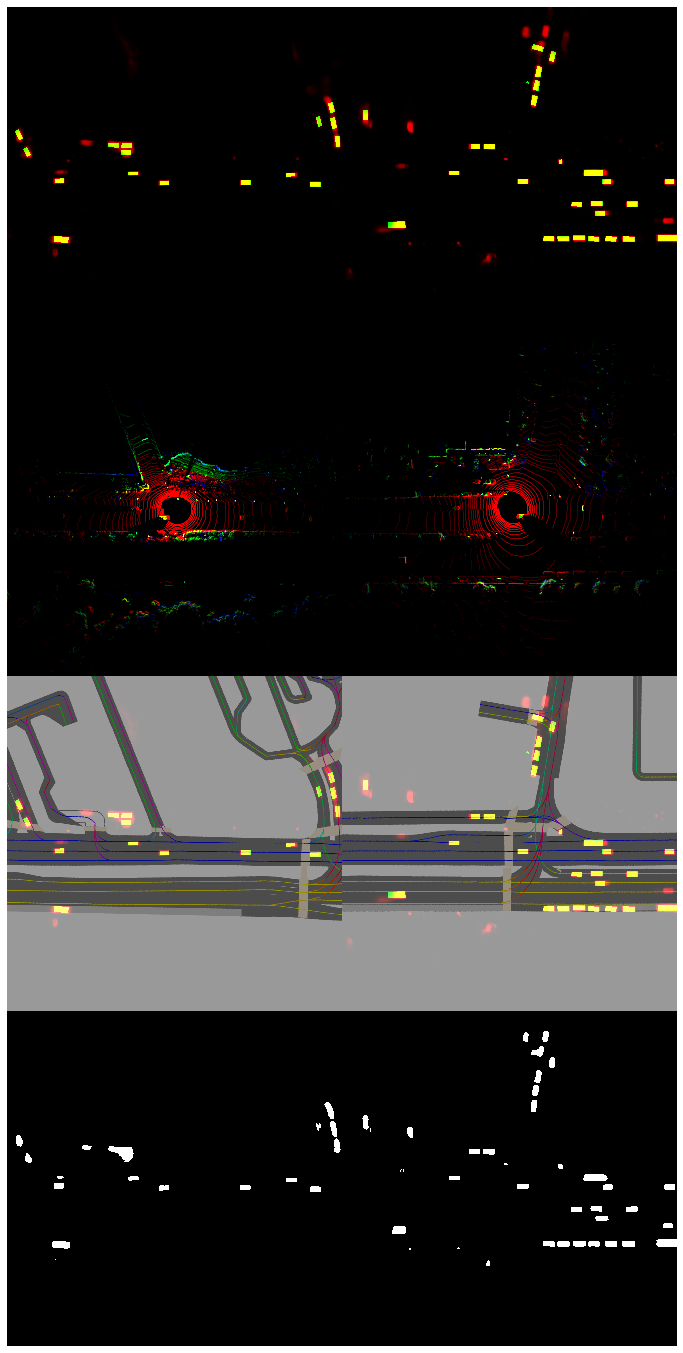


Loss: 0.022096874
Epoch 8


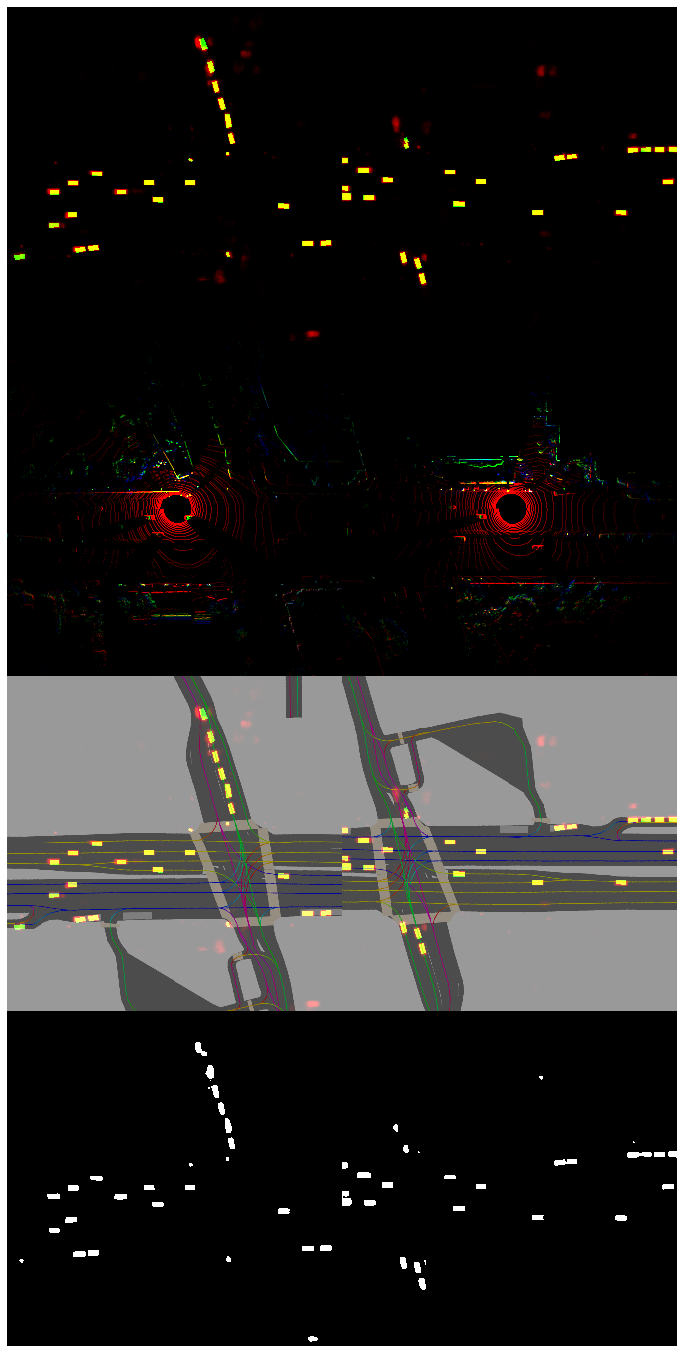


Loss: 0.021194085
Epoch 9


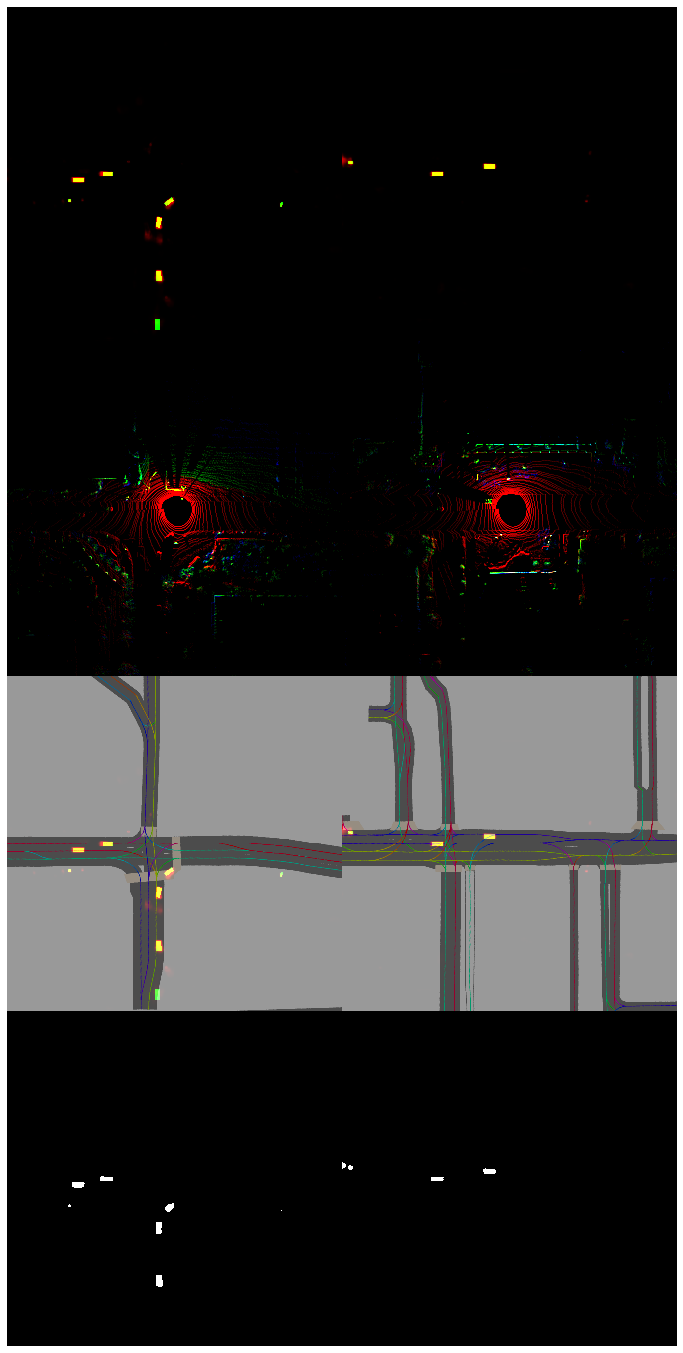


Loss: 0.0200259
Epoch 10


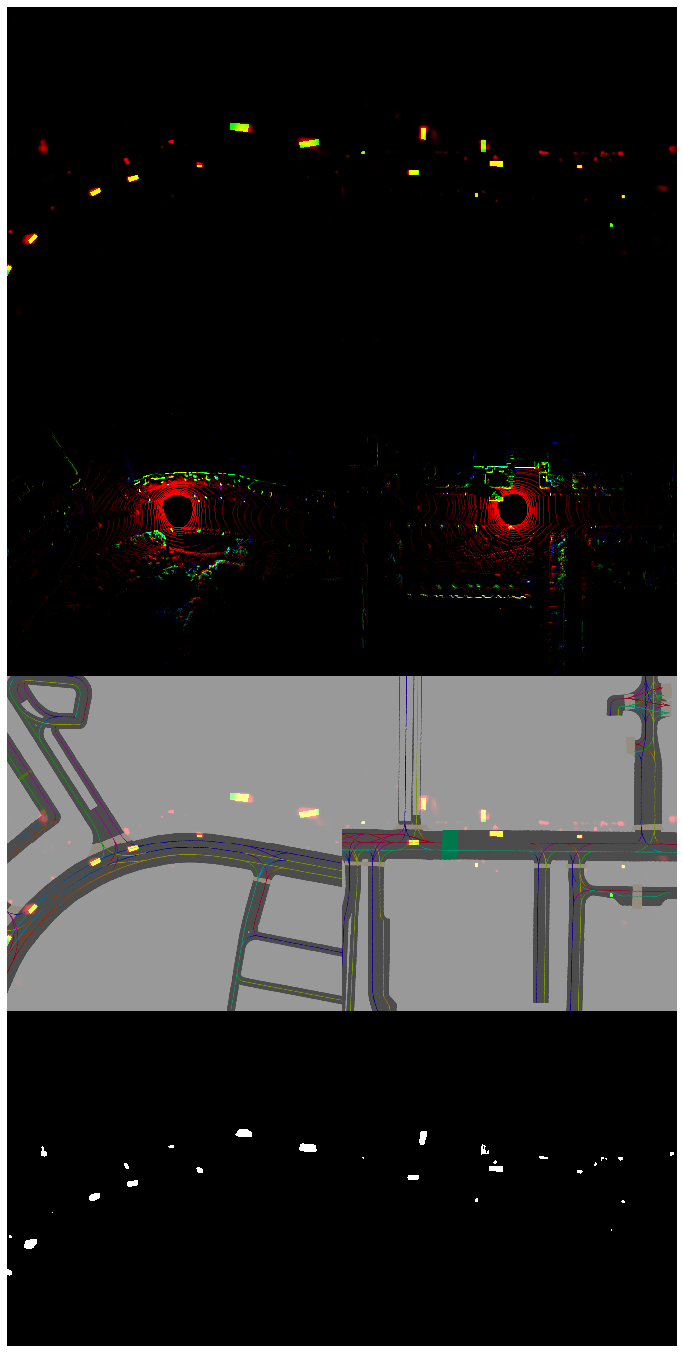


Loss: 0.019377392
Epoch 11


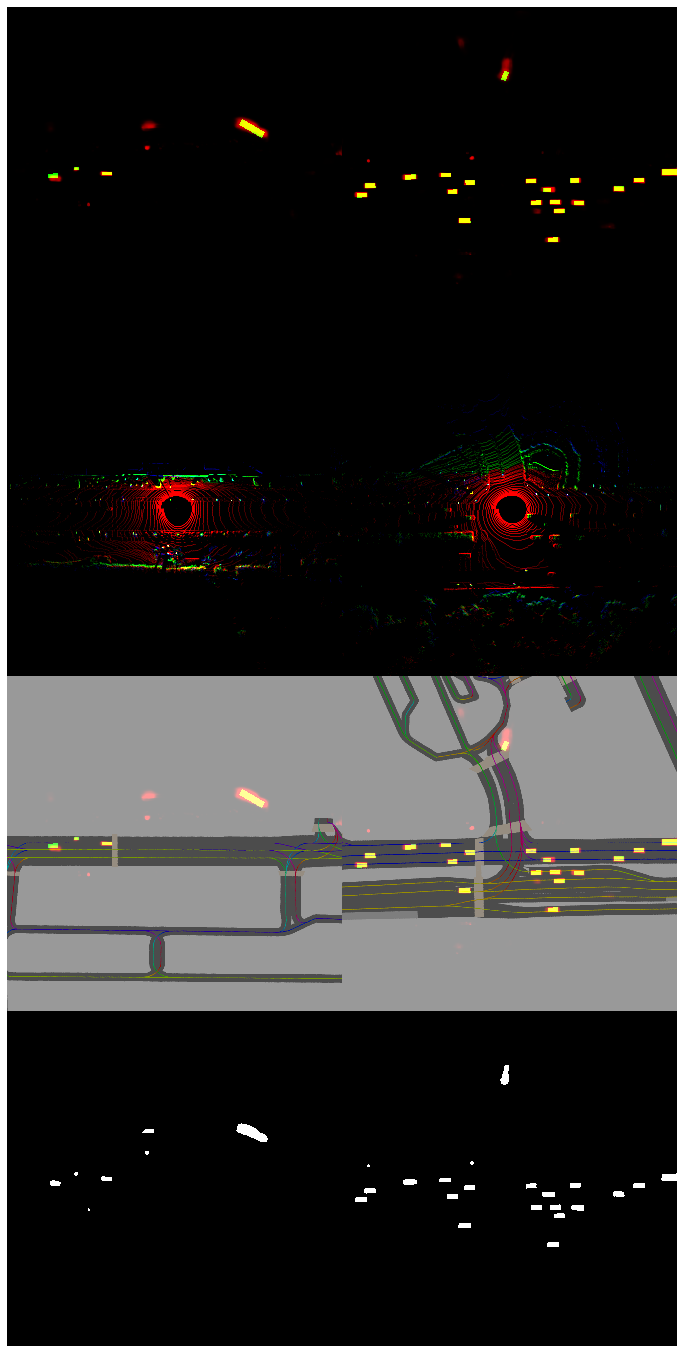


Loss: 0.018406669
Epoch 12


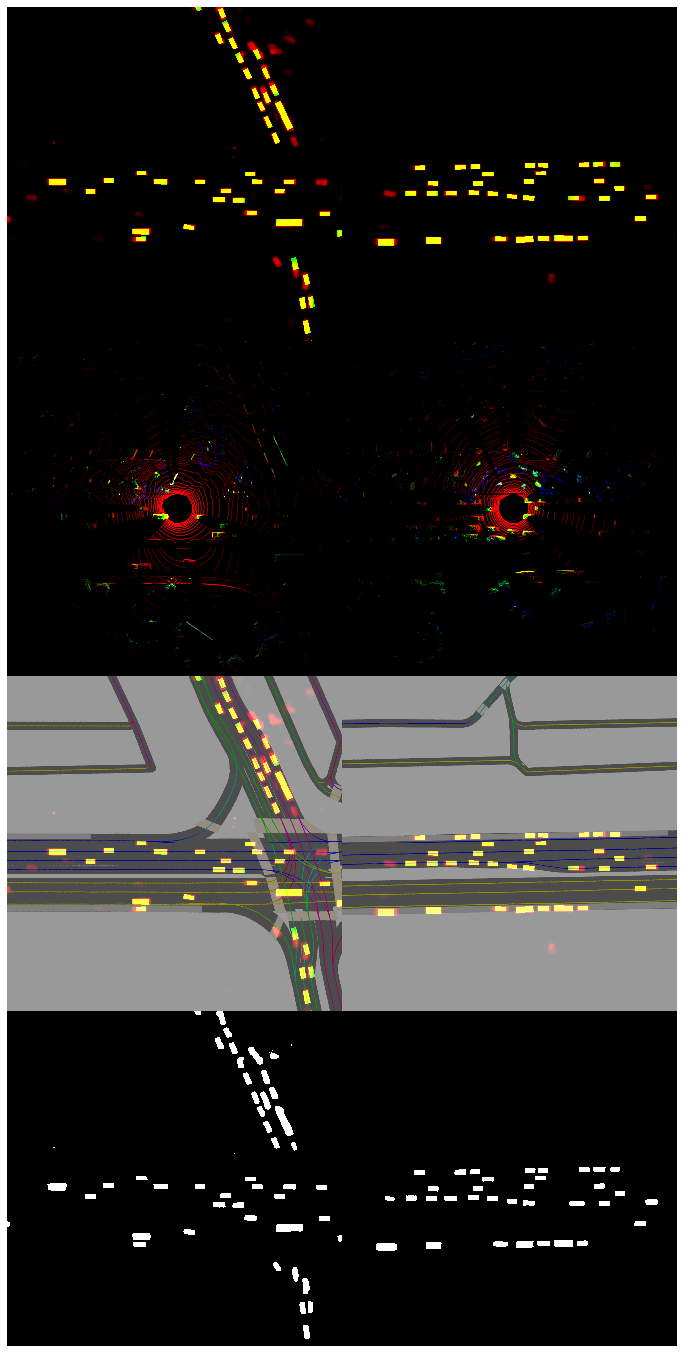


Loss: 0.017981661
Epoch 13


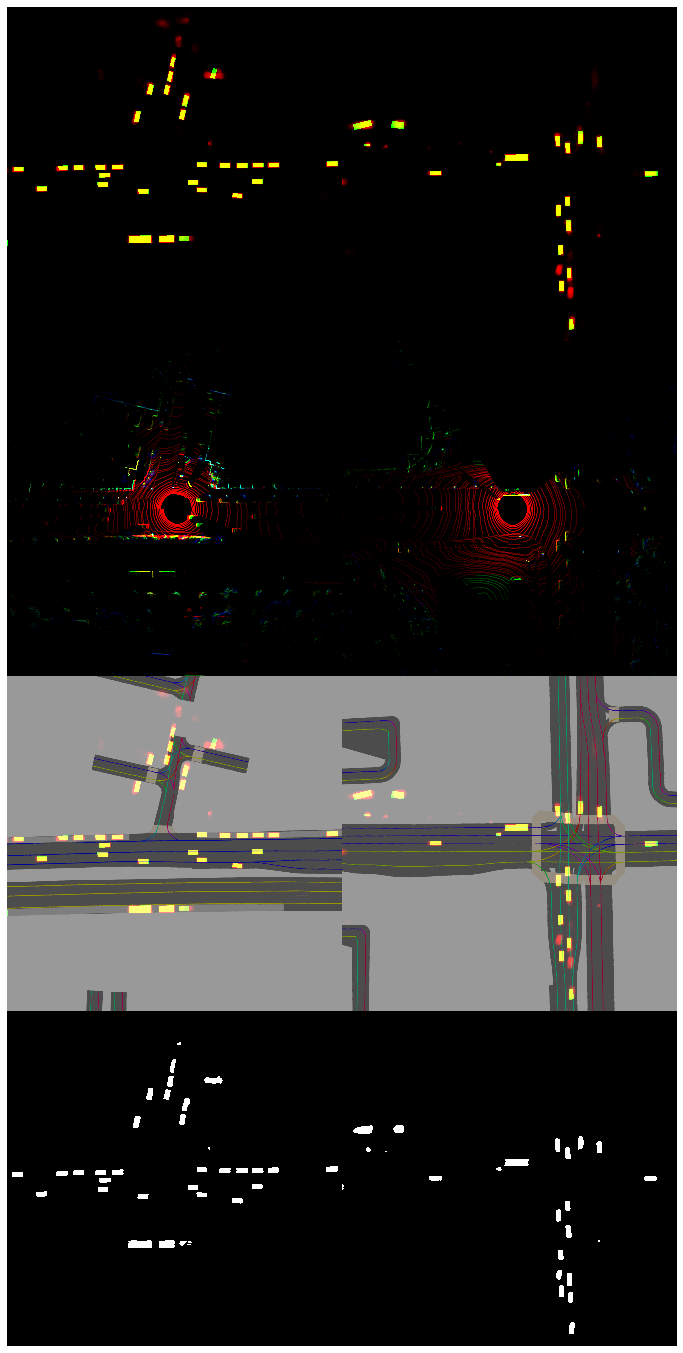


Loss: 0.017019764
Epoch 14


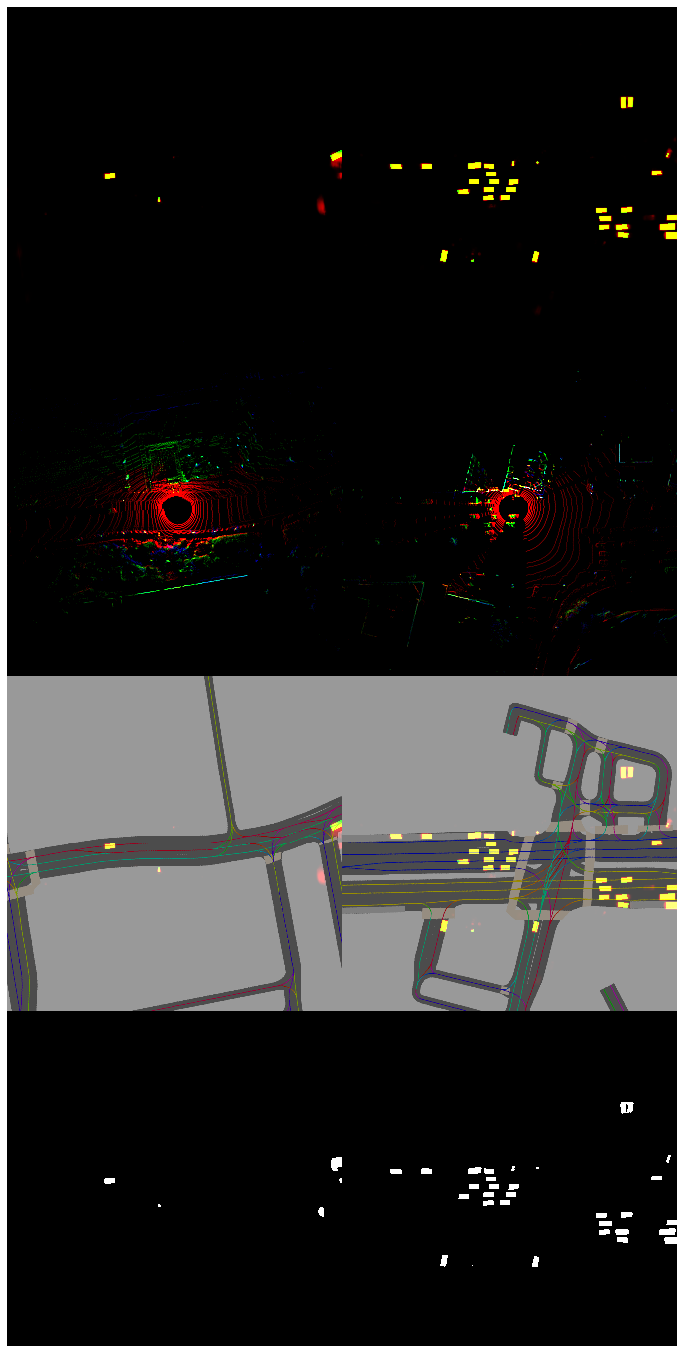


Loss: 0.017294295
Epoch 15


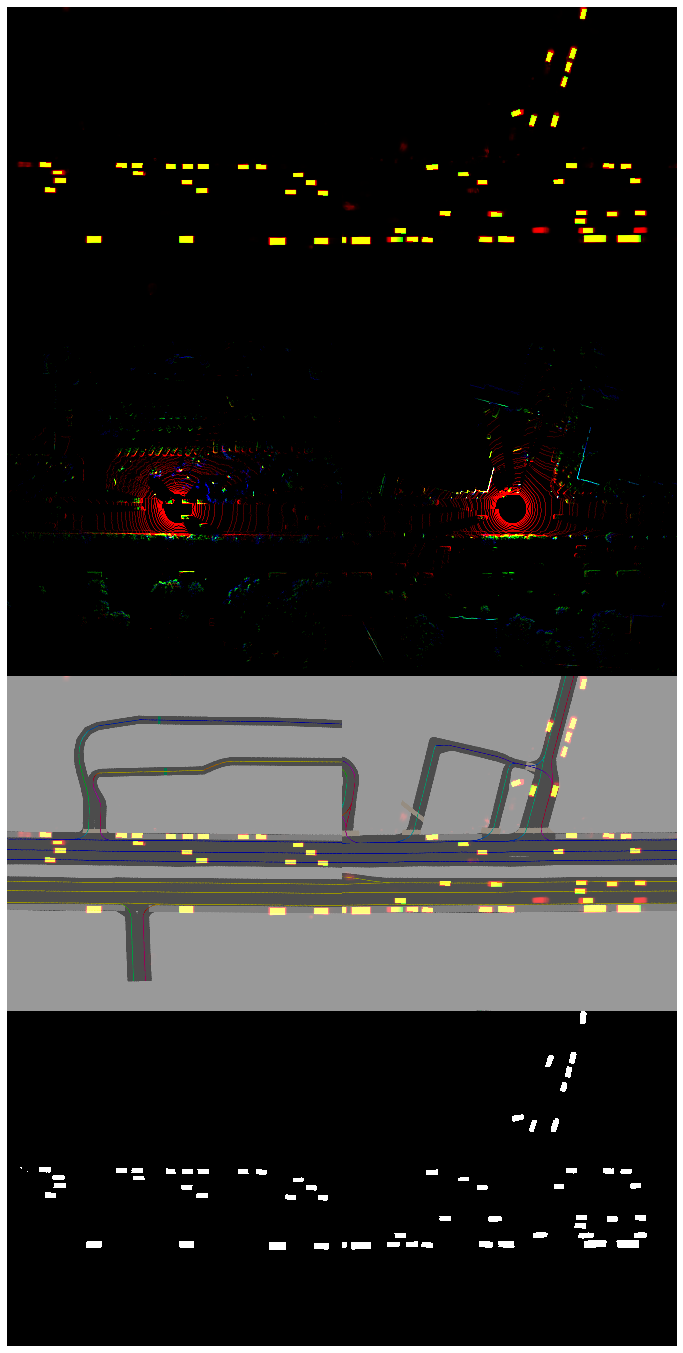


Loss: 0.016169544
Epoch 16


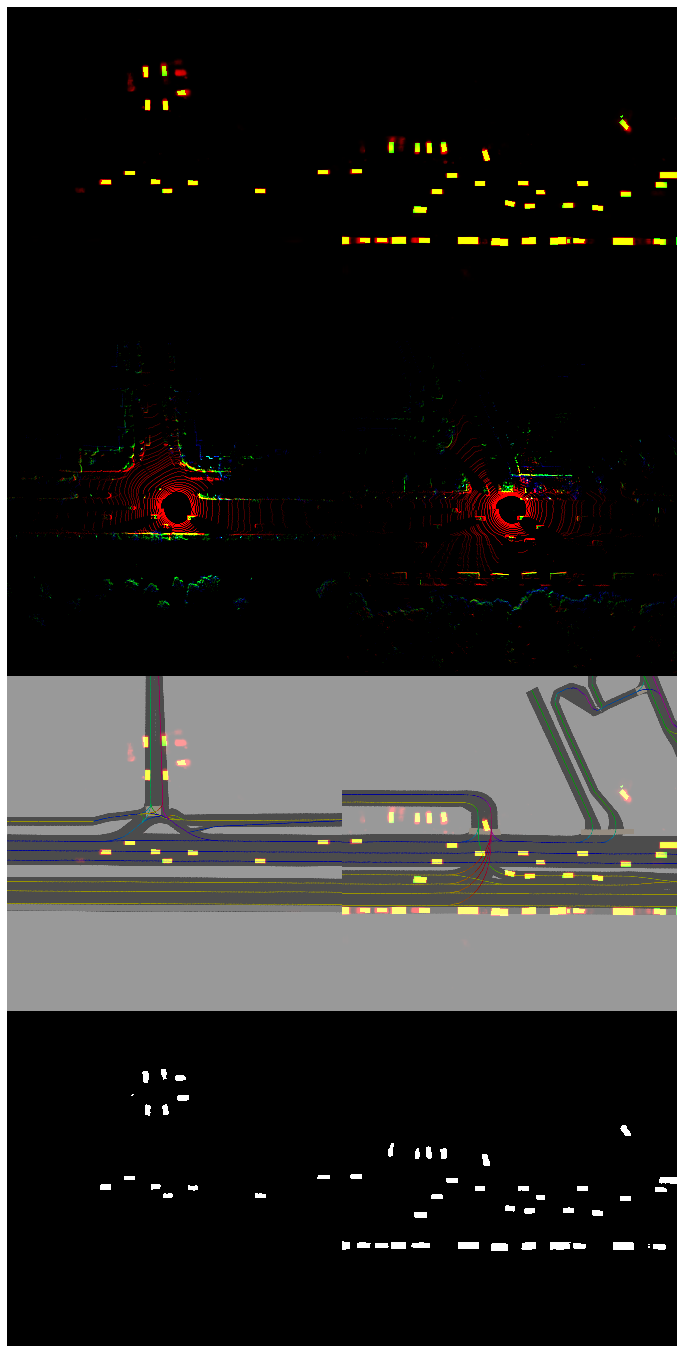


Loss: 0.017328639
Epoch 17


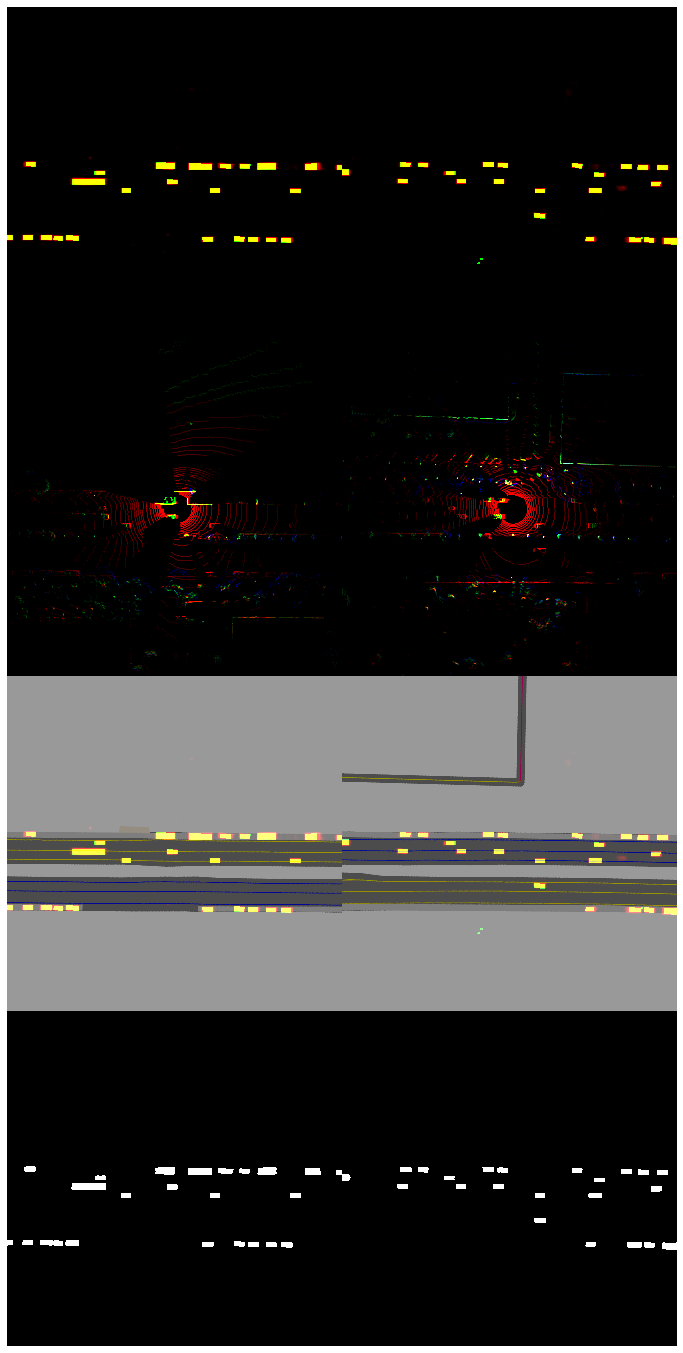


Loss: 0.015700173
Epoch 18


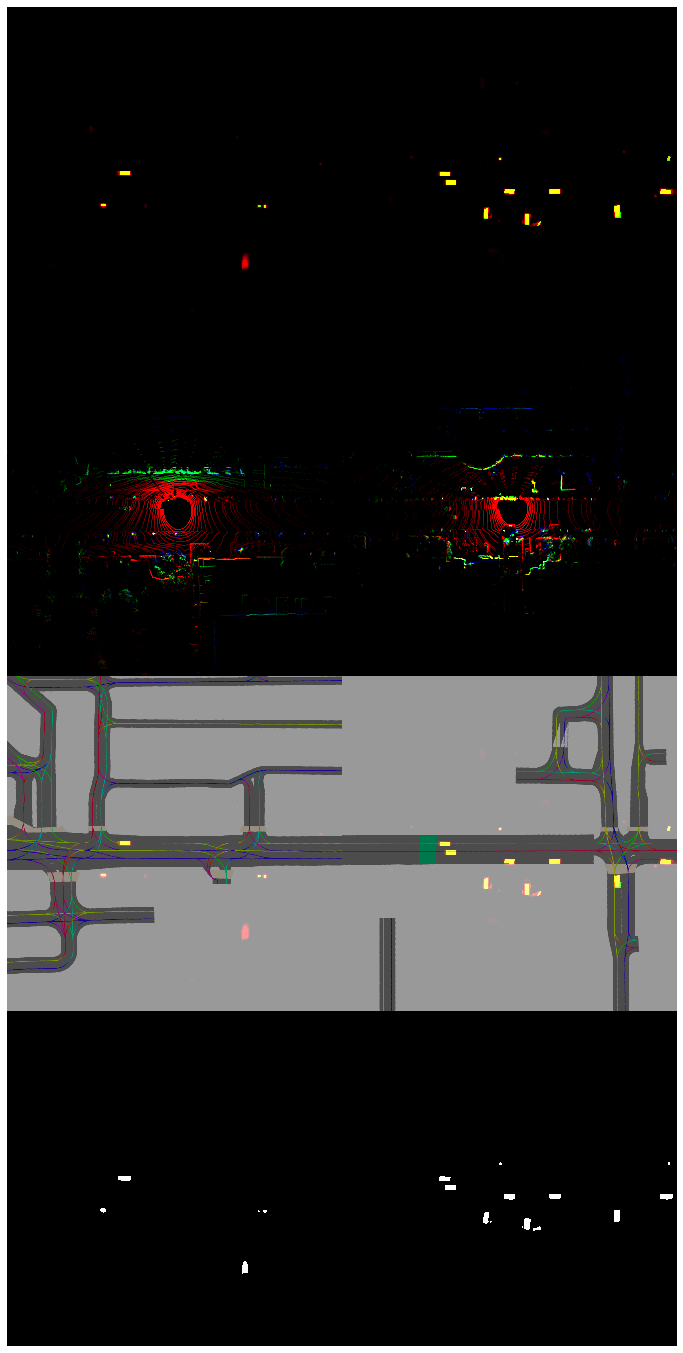


Loss: 0.015396089
Epoch 19


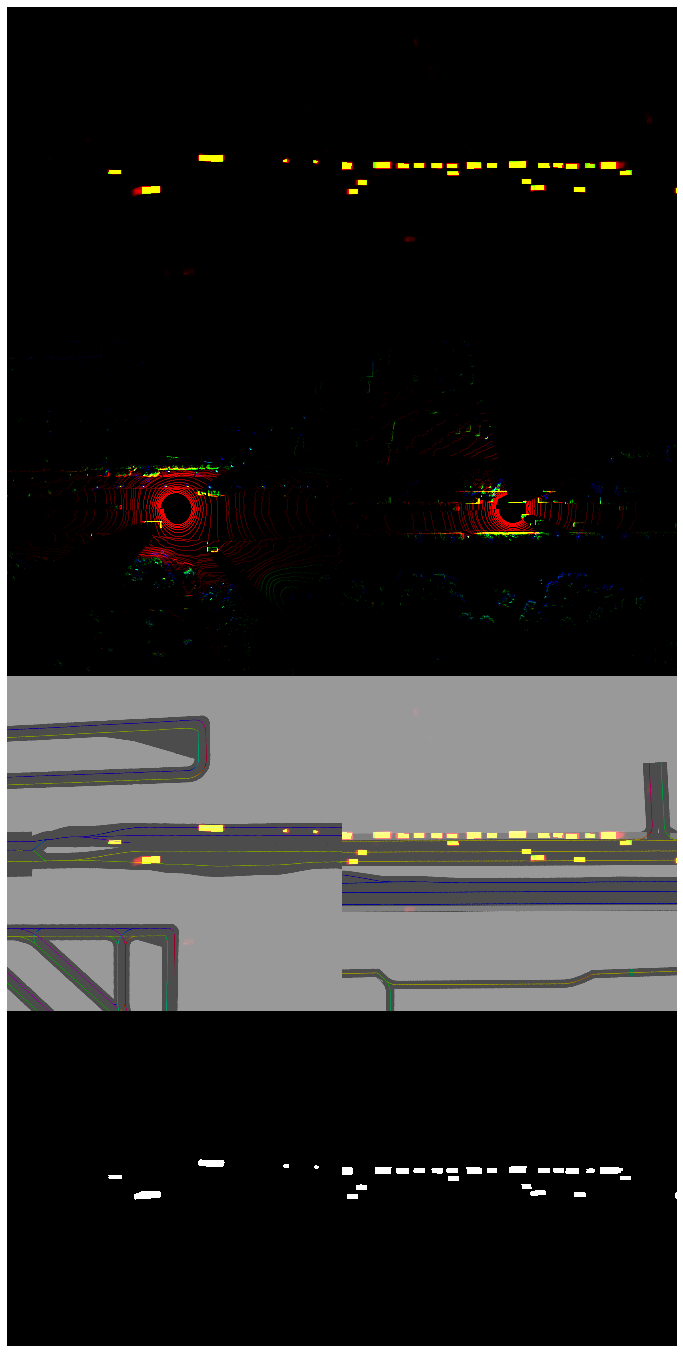


Loss: 0.015087507
Epoch 20


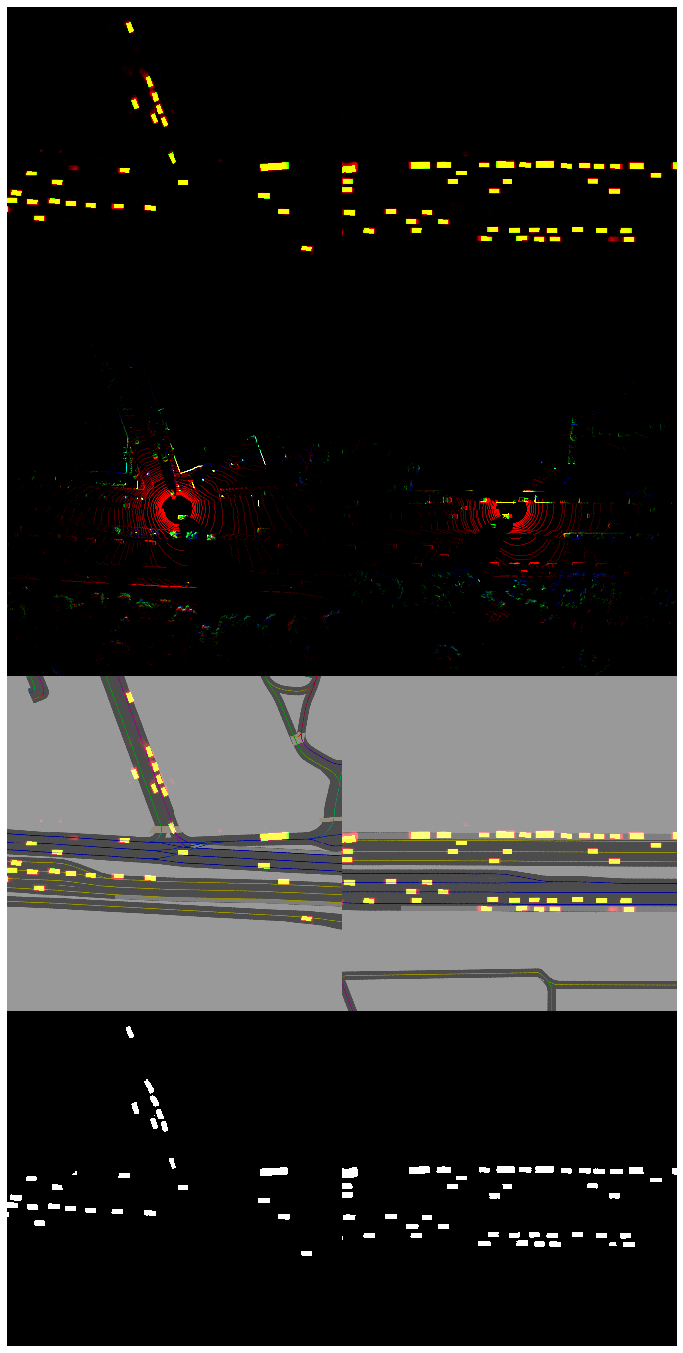


Loss: 0.01522484


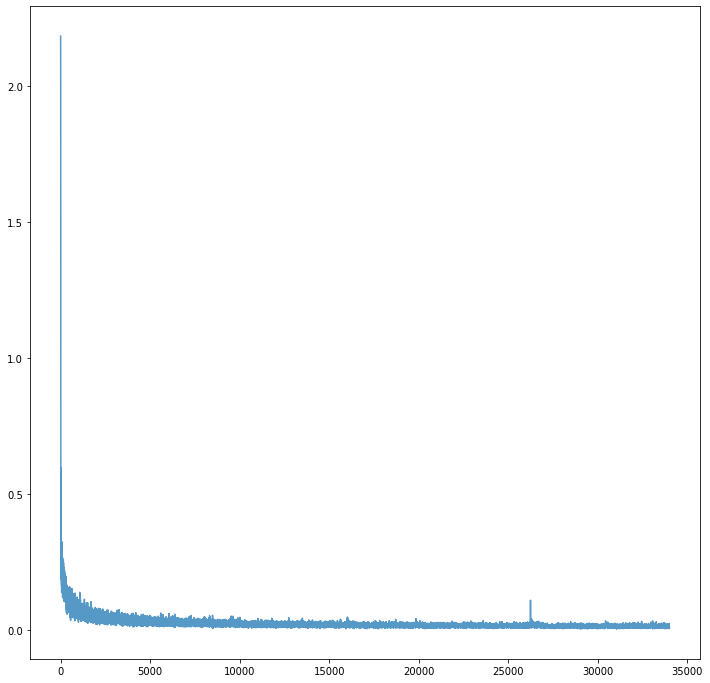

In [26]:
batch_size = 8
epochs = 20

model = get_unet_model(num_output_classes=len(classes)+1)
model = model.to(device)

optim = torch.optim.Adam(model.parameters(), lr=1e-3)
dataloader = torch.utils.data.DataLoader(train_dataset, batch_size, shuffle=True, num_workers=os.cpu_count())

all_losses = []

for epoch in range(1, epochs+1):
    print("Epoch", epoch)
    
    epoch_losses = []
    progress_bar = tqdm_notebook(dataloader)
    
    for ii, (X, target, sample_ids) in enumerate(progress_bar):
        X = X.to(device)  # [N, 3, H, W]
        target = target.to(device)  # [N, H, W] with class indices (0, 1)
        prediction = model(X)  # [N, 2, H, W]
        loss = F.cross_entropy(prediction, target, weight=class_weights)

        optim.zero_grad()
        loss.backward()
        optim.step()
        
        epoch_losses.append(loss.detach().cpu().numpy())

        if ii == 0:
            visualize_predictions(X, prediction, target)
    
    print("Loss:", np.mean(epoch_losses))
    all_losses.extend(epoch_losses)
    
    checkpoint_filename = "unet_checkpoint_epoch_{}.pth".format(epoch)
    checkpoint_filepath = os.path.join(ARTIFACTS_FOLDER, checkpoint_filename)
    torch.save(model.state_dict(), checkpoint_filepath)
    
plt.figure(figsize=(12,12))
plt.plot(all_losses, alpha=0.75)
plt.show()

#### You can interpret the above visualizations as follows:  
There are four different visualizations stacked on top of eachother:
1. The top images have two color channels: red for predictions, green for targets, with red+green=yellow. In other words:  
> **Black**: True Negative  
**Green**: False Negative  
**Yellow**: True Positive  
**Red**: False Positive 
2. The input image
3. The input image or semantic input map blended together with targets+predictions
4. The predictions thresholded at 0.5 probability.

## D. Inference and postprocessing

In [27]:
input_filepaths = sorted(glob.glob(os.path.join(validation_data_folder, "*_input.png")))
target_filepaths = sorted(glob.glob(os.path.join(validation_data_folder, "*_target.png")))
map_filepaths = sorted(glob.glob(os.path.join(validation_data_folder, "*_map.png")))

batch_size=16
validation_dataset = BEVImageDataset(input_filepaths, target_filepaths, map_filepaths)
validation_dataloader = torch.utils.data.DataLoader(validation_dataset, batch_size, shuffle=False, num_workers=os.cpu_count())


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = get_unet_model(num_output_classes=1+len(classes))
model = model.to(device)

epoch_to_load=20
checkpoint_filename = "unet_checkpoint_epoch_{}.pth".format(epoch_to_load)
checkpoint_filepath = os.path.join(ARTIFACTS_FOLDER, checkpoint_filename)
model.load_state_dict(torch.load(checkpoint_filepath))

IncompatibleKeys(missing_keys=[], unexpected_keys=[])

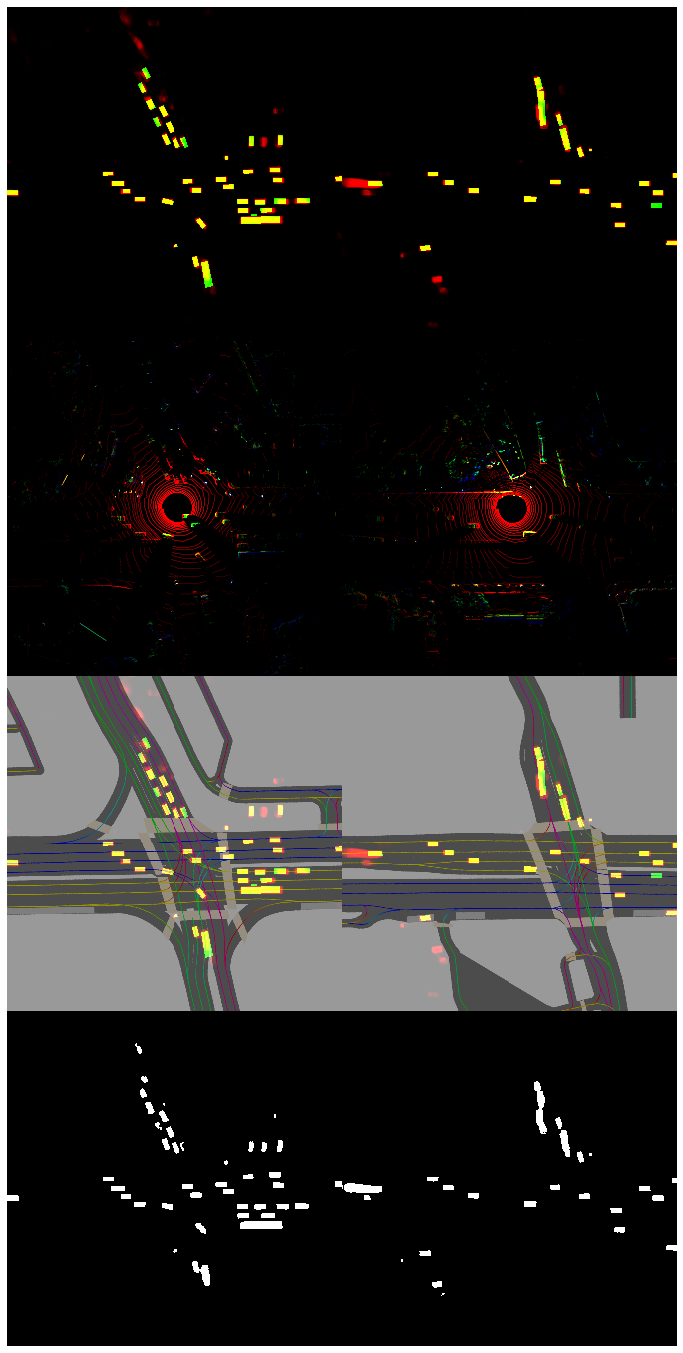


Mean loss: 0.08086387


In [28]:
progress_bar = tqdm_notebook(validation_dataloader)

targets = np.zeros((len(target_filepaths), 336, 336), dtype=np.uint8)

# We quantize to uint8 here to conserve memory. We're allocating >20GB of memory otherwise.
predictions = np.zeros((len(target_filepaths), 1+len(classes), 336, 336), dtype=np.uint8)

sample_tokens = []
all_losses = []

with torch.no_grad():
    model.eval()
    for ii, (X, target, batch_sample_tokens) in enumerate(progress_bar):

        offset = ii*batch_size
        targets[offset:offset+batch_size] = target.numpy()
        sample_tokens.extend(batch_sample_tokens)
        
        X = X.to(device)  # [N, 1, H, W]
        target = target.to(device)  # [N, H, W] with class indices (0, 1)
        prediction = model(X)  # [N, 2, H, W]
        loss = F.cross_entropy(prediction, target, weight=class_weights)
        all_losses.append(loss.detach().cpu().numpy())
        
        prediction = F.softmax(prediction, dim=1)
        
        prediction_cpu = prediction.cpu().numpy()
        predictions[offset:offset+batch_size] = np.round(prediction_cpu*255).astype(np.uint8)
        
        # Visualize the first prediction
        if ii == 0:
            visualize_predictions(X, prediction, target, apply_softmax=False)
            
print("Mean loss:", np.mean(all_losses))

In [30]:
# Get probabilities for non-background
predictions_non_class0 = 255 - predictions[:,0]

/home/gzuidhof/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  del sys.path[0]


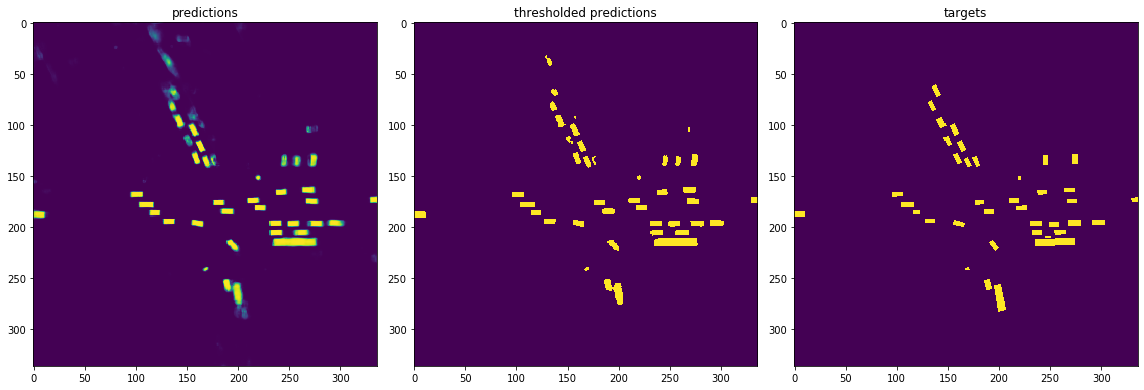

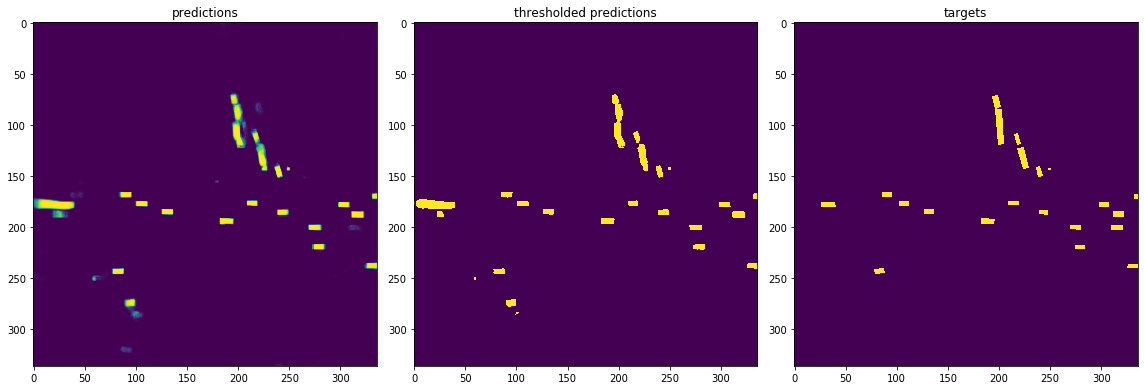

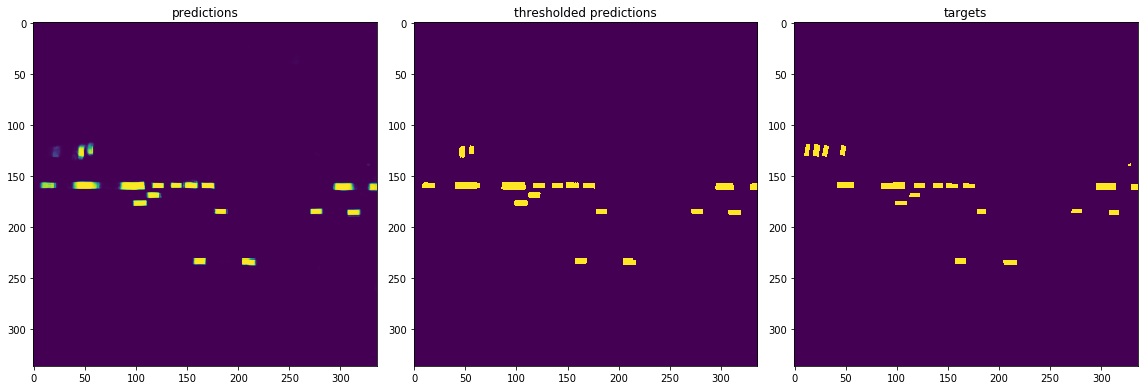

In [31]:
# Arbitrary threshold in our system to create a binary image to fit boxes around.
background_threshold = 255//2

for i in range(3):
    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(16, 6))
    axes[0].imshow(predictions_non_class0[i])
    axes[0].set_title("predictions")
    axes[1].imshow(predictions_non_class0[i] > background_threshold)
    axes[1].set_title("thresholded predictions")
    axes[2].imshow((targets[i] > 0).astype(np.uint8), interpolation="nearest")
    axes[2].set_title("targets")
    fig.tight_layout()
    fig.show()



100%|██████████| 5040/5040 [00:00<00:00, 5467.95it/s]
/home/gzuidhof/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  app.launch_new_instance()


<Figure size 864x864 with 0 Axes>

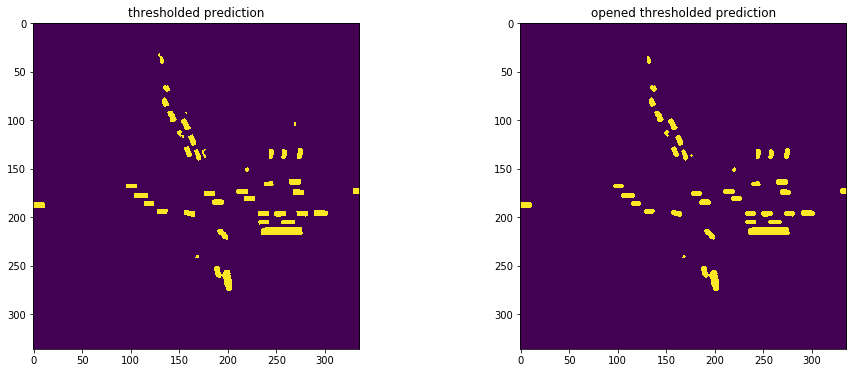

In [32]:
# We perform an opening morphological operation to filter tiny detections
# Note that this may be problematic for classes that are inherently small (e.g. pedestrians)..
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(3,3))
predictions_opened = np.zeros((predictions_non_class0.shape), dtype=np.uint8)

for i, p in enumerate(tqdm(predictions_non_class0)):
    thresholded_p = (p > background_threshold).astype(np.uint8)
    predictions_opened[i] = cv2.morphologyEx(thresholded_p, cv2.MORPH_OPEN, kernel)

plt.figure(figsize=(12,12))
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))
axes[0].imshow(predictions_non_class0[0] > 255//2)
axes[0].set_title("thresholded prediction")
axes[1].imshow(predictions_opened[0])
axes[1].set_title("opened thresholded prediction")
fig.show()

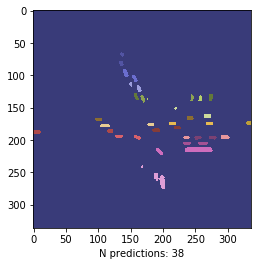

In [33]:
# Sanity check: let's count the amount of connected components in an image
labels, n = scipy.ndimage.label(predictions_opened[0])
plt.imshow(labels, cmap="tab20b")
plt.xlabel("N predictions: {}".format(n))
plt.show()

The above image looks pretty well separated, although some boxes seem to be wrongly merged together. Let's continue.


For each scene we fit boxes to the segmentations. For each box and each class we write it's probability in the center pixel.



Total amount of boxes: 127980


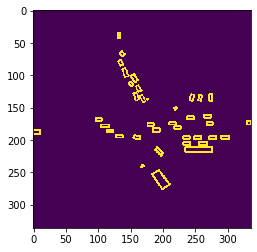

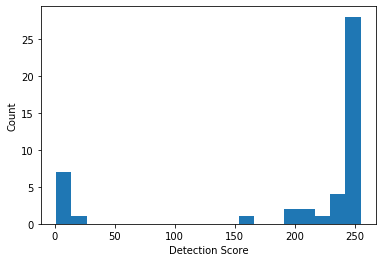

In [35]:
detection_boxes = []
detection_scores = []
detection_classes = []

for i in tqdm_notebook(range(len(predictions))):
    prediction_opened = predictions_opened[i]
    probability_non_class0 = predictions_non_class0[i]
    class_probability = predictions[i]

    sample_boxes = []
    sample_detection_scores = []
    sample_detection_classes = []
    
    _, contours, hierarchy = cv2.findContours(prediction_opened, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE) 
    
    for cnt in contours:
        rect = cv2.minAreaRect(cnt)
        box = cv2.boxPoints(rect)
        
        # Let's take the center pixel value as the confidence value
        box_center_index = np.int0(np.mean(box, axis=0))
        
        for class_index in range(len(classes)):
            box_center_value = class_probability[class_index+1, box_center_index[1], box_center_index[0]]
            
            # Let's remove candidates with very low probability
            if box_center_value < 0.01:
                continue
            
            box_center_class = classes[class_index]

            box_detection_score = box_center_value
            sample_detection_classes.append(box_center_class)
            sample_detection_scores.append(box_detection_score)
            sample_boxes.append(box)
        
    
    detection_boxes.append(np.array(sample_boxes))
    detection_scores.append(sample_detection_scores)
    detection_classes.append(sample_detection_classes)
    
print("Total amount of boxes:", np.sum([len(x) for x in detection_boxes]))
    

# Visualize the boxes in the first sample
t = np.zeros_like(predictions_opened[0])
for sample_boxes in detection_boxes[0]:
    box_pix = np.int0(sample_boxes)
    cv2.drawContours(t,[box_pix],0,(255),2)
plt.imshow(t)
plt.show()

# Visualize their probabilities
plt.hist(detection_scores[0], bins=20)
plt.xlabel("Detection Score")
plt.ylabel("Count")
plt.show()


Now let's load the groundtruth. The nuScenes SDK format provides the EvalBox and EvalBoxes class that allows us to represent the targets and predictions in a structured way, and visualize them using them using built-in functions. See the [nuScenes Detection Task](https://github.com/lyft/nuscenes-devkit/tree/master/python-sdk/nuscenes/eval/detection) page in the SDK.

In [36]:
from lyft_dataset_sdk.eval.detection.mAP_evaluation import Box3D, recall_precision

def load_groundtruth_boxes(nuscenes, sample_tokens):
    gt_box3ds = []

    # Load annotations and filter predictions and annotations.
    for sample_token in tqdm_notebook(sample_tokens):

        sample = nuscenes.get('sample', sample_token)
        sample_annotation_tokens = sample['anns']

        sample_lidar_token = sample["data"]["LIDAR_TOP"]
        lidar_data = level5data.get("sample_data", sample_lidar_token)
        ego_pose = level5data.get("ego_pose", lidar_data["ego_pose_token"])
        ego_translation = np.array(ego_pose['translation'])
        
        for sample_annotation_token in sample_annotation_tokens:
            sample_annotation = nuscenes.get('sample_annotation', sample_annotation_token)
            sample_annotation_translation = sample_annotation['translation']
            
            class_name = sample_annotation['category_name']
            
            box3d = Box3D(
                sample_token=sample_token,
                translation=sample_annotation_translation,
                size=sample_annotation['size'],
                rotation=sample_annotation['rotation'],
                name=class_name
            )
            gt_box3ds.append(box3d)
            
    return gt_box3ds

gt_box3ds = load_groundtruth_boxes(level5data, sample_tokens)

Next we take our predicted boxes, transform them back into world space and make them 3D.

In [37]:
pred_box3ds = []

# This could use some refactoring..
for (sample_token, sample_boxes, sample_detection_scores, sample_detection_class) in tqdm_notebook(zip(sample_tokens, detection_boxes, detection_scores, detection_classes), total=len(sample_tokens)):
    sample_boxes = sample_boxes.reshape(-1, 2) # (N, 4, 2) -> (N*4, 2)
    sample_boxes = sample_boxes.transpose(1,0) # (N*4, 2) -> (2, N*4)

    # Add Z dimension
    sample_boxes = np.vstack((sample_boxes, np.zeros(sample_boxes.shape[1]),)) # (2, N*4) -> (3, N*4)

    sample = level5data.get("sample", sample_token)
    sample_lidar_token = sample["data"]["LIDAR_TOP"]
    lidar_data = level5data.get("sample_data", sample_lidar_token)
    lidar_filepath = level5data.get_sample_data_path(sample_lidar_token)
    ego_pose = level5data.get("ego_pose", lidar_data["ego_pose_token"])
    ego_translation = np.array(ego_pose['translation'])

    global_from_car = transform_matrix(ego_pose['translation'],
                                       Quaternion(ego_pose['rotation']), inverse=False)

    car_from_voxel = np.linalg.inv(create_transformation_matrix_to_voxel_space(bev_shape, voxel_size, (0, 0, z_offset)))


    global_from_voxel = np.dot(global_from_car, car_from_voxel)
    sample_boxes = transform_points(sample_boxes, global_from_voxel)

    # We don't know at where the boxes are in the scene on the z-axis (up-down), let's assume all of them are at
    # the same height as the ego vehicle.
    sample_boxes[2,:] = ego_pose["translation"][2]


    # (3, N*4) -> (N, 4, 3)
    sample_boxes = sample_boxes.transpose(1,0).reshape(-1, 4, 3)


    # We don't know the height of our boxes, let's assume every object is the same height.
    box_height = 1.75

    # Note: Each of these boxes describes the ground corners of a 3D box.
    # To get the center of the box in 3D, we'll have to add half the height to it.
    sample_boxes_centers = sample_boxes.mean(axis=1)
    sample_boxes_centers[:,2] += box_height/2

    # Width and height is arbitrary - we don't know what way the vehicles are pointing from our prediction segmentation
    # It doesn't matter for evaluation, so no need to worry about that here.
    # Note: We scaled our targets to be 0.8 the actual size, we need to adjust for that
    sample_lengths = np.linalg.norm(sample_boxes[:,0,:] - sample_boxes[:,1,:], axis=1) * 1/box_scale
    sample_widths = np.linalg.norm(sample_boxes[:,1,:] - sample_boxes[:,2,:], axis=1) * 1/box_scale
    
    sample_boxes_dimensions = np.zeros_like(sample_boxes_centers) 
    sample_boxes_dimensions[:,0] = sample_widths
    sample_boxes_dimensions[:,1] = sample_lengths
    sample_boxes_dimensions[:,2] = box_height

    for i in range(len(sample_boxes)):
        translation = sample_boxes_centers[i]
        size = sample_boxes_dimensions[i]
        class_name = sample_detection_class[i]
        ego_distance = float(np.linalg.norm(ego_translation - translation))
    
        
        # Determine the rotation of the box
        v = (sample_boxes[i,0] - sample_boxes[i,1])
        v /= np.linalg.norm(v)
        r = R.from_dcm([
            [v[0], -v[1], 0],
            [v[1],  v[0], 0],
            [   0,     0, 1],
        ])
        quat = r.as_quat()
        # XYZW -> WXYZ order of elements
        quat = quat[[3,0,1,2]]
        
        detection_score = float(sample_detection_scores[i])

        
        box3d = Box3D(
            sample_token=sample_token,
            translation=list(translation),
            size=list(size),
            rotation=list(quat),
            name=class_name,
            score=detection_score
        )
        pred_box3ds.append(box3d)


In [48]:
import json

gt = [b.serialize() for b in gt_box3ds]

pred = [b.serialize() for b in pred_box3ds]


In [49]:
with open(os.path.join(ARTIFACTS_FOLDER, "gt.json"), "w") as f:
    json.dump(gt, f)

with open(os.path.join(ARTIFACTS_FOLDER, "pred.json"), "w") as f:
    json.dump(pred, f)

In [52]:
!python ../lyft_dataset_sdk/eval/detection/mAP_evaluation.py --pred_file "./artifacts/pred.json" --gt_file "./artifacts/gt.json" --iou_threshold 0.4

Class_names =  ['animal', 'bicycle', 'bus', 'car', 'motorcycle', 'other_vehicle', 'pedestrian', 'truck']
Average per class mean average precision =  0.10458624970399849
('animal', 0.0)
('bicycle', 0.014827256648354046)
('bus', 0.07114362365576843)
('car', 0.4644436416741515)
('motorcycle', 0.031743736796870606)
('other_vehicle', 0.240433992246761)
('pedestrian', 0.002291803782829482)
('truck', 0.011805942827252867)
